In [1]:
from lemaitre import georges
georges.setup_logger(level='INFO')
from lemaitre import bandpasses

filterlib = bandpasses.get_filterlib()

2025-03-20 14:19:33,171 INFO Note: NumExpr detected 28 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 16.
2025-03-20 14:19:33,171 INFO NumExpr defaulting to 16 threads.
2025-03-20 14:19:33,438 INFO loading lemaitre filterlib from /home/okc/.cache/bbf/lemaitre_flib.default.391295c5c9244927458264594f9bca92b862a8cc8f909d42e0104055288f5979.pkl


In [2]:
import skysurvey
import numpy as np
import sncosmo
import pandas
from src import *
from tqdm.auto import tqdm
import jax.numpy as jnp
import pickle

2025-03-20 14:19:34,542 INFO sparse_dot_mkl found. Building hessian should be faster.
2025-03-20 14:19:34,622 INFO loading lemaitre filterlib from /home/okc/.cache/bbf/lemaitre_flib.default.391295c5c9244927458264594f9bca92b862a8cc8f909d42e0104055288f5979.pkl
INFO:2025-03-20 14:19:36,691:jax._src.xla_bridge:945: Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2025-03-20 14:19:36,691 INFO Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:2025-03-20 14:19:36,695:jax._src.xla_bridge:945: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory
2025-03-20 14:19:36,695 INFO Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory


In [3]:
import warnings
from iminuit.warnings import IMinuitWarning

warnings.filterwarnings("ignore", category=IMinuitWarning)

In [4]:
%matplotlib inline

In [5]:
survey_colors = dict(ZTF="tab:blue", SNLS="tab:orange", HSC="tab:green")

## 2M++ halos loading

When drawing from the 2M++ grid, enforce z_max=0.11677 otherwise it's not isotrope 

In [6]:
z_max = 0.11677295
from astropy.cosmology import FlatLambdaCDM

cosmo = FlatLambdaCDM(name="2m++", H0=68.1, Om0=0.306)

##### First loading

In [7]:
import h5py

In [8]:
with h5py.File("./data/hbt_subhalos_1.hdf5", "r") as file:
    print("Keys: %s" % file.keys())
    print(list(file["Subhalos"]))
    cosmo_params = {
        params: np.array(file["Cosmology"][params])[0]
        for params in list(file["Cosmology"])
    }
    positions = np.array(file["Subhalos"]["ComovingAveragePosition"])
    positions_mostbound = np.array(file["Subhalos"]["ComovingMostBoundPosition"])
    masses = np.array(file["Subhalos"]["BoundM200Crit"])
    velocities = np.array(file["Subhalos"]["PhysicalAverageVelocity"])
    ids = np.array(file["Subhalos"]["HostHaloId"])
    rmax = np.array(file["Subhalos"]["RmaxComoving"])

Keys: <KeysViewHDF5 ['Cosmology', 'Subhalos']>
['BoundM200Crit', 'BoundR200CritComoving', 'ComovingAveragePosition', 'ComovingMostBoundPosition', 'HostHaloId', 'Nbound', 'PhysicalAverageVelocity', 'PhysicalMostBoundVelocity', 'RmaxComoving', 'TrackId', 'VmaxPhysical']


In [10]:
with h5py.File("./data/delta_dm_cic_1.hdf5", "r") as file:
    print("Keys: %s" % file.keys())
    print(file["Header"])
    delta = np.array(file["delta_dm"])

with h5py.File("./data/velocity_cic_1.hdf5", "r") as file:
    print("Keys: %s" % file.keys())
    print(file["Header"])
    vpec = np.array(file["velocity_field_radial"])
    v_x = np.array(file["velocity_field_0"])
    v_y = np.array(file["velocity_field_1"])
    v_z = np.array(file["velocity_field_2"])

Keys: <KeysViewHDF5 ['Header', 'delta_dm']>
<HDF5 group "/Header" (0 members)>
Keys: <KeysViewHDF5 ['Header', 'velocity_field_0', 'velocity_field_1', 'velocity_field_2', 'velocity_field_radial']>
<HDF5 group "/Header" (0 members)>


In [11]:
v = np.concatenate(
    [
        v_x.reshape(256, 256, 256, 1),
        v_y.reshape(256, 256, 256, 1),
        v_z.reshape(256, 256, 256, 1),
    ],
    axis=3,
)

In [12]:
halos = pandas.DataFrame(
    {
        "pos_x": positions.T[0] - 500,
        "pos_y": positions.T[1] - 500,
        "pos_z": positions.T[2] - 500,
        "vx": velocities.T[0],
        "vy": velocities.T[1],
        "vz": velocities.T[2],
        "M200c": masses,
        "halo_id": ids,
        "Rmax": rmax,
    }
)


halos["d_c"] = np.sqrt(halos.pos_x**2 + halos.pos_y**2 + halos.pos_z**2)

halos["vpec"] = (
    halos.pos_x * halos.vx + halos.pos_y * halos.vy + halos.pos_z * halos.vz
) / halos.d_c

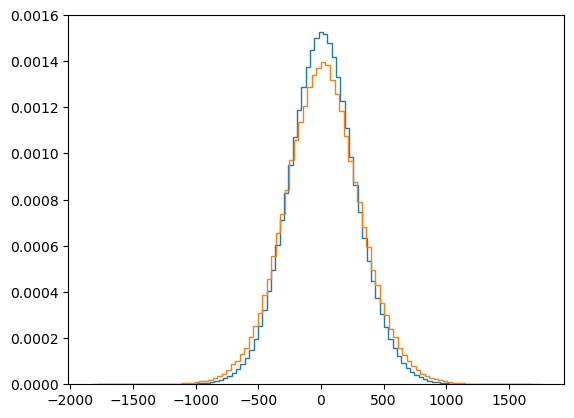

In [13]:
plt.hist(vpec.ravel(), bins=100, density=True, histtype="step")
_ = plt.hist(halos.vpec, bins=100, density=True, histtype="step")

In [14]:
from scipy.interpolate import interp1d

dc_to_z = interp1d(
    cosmo.comoving_distance(np.linspace(1e-3, 0.5, 10000)),
    np.linspace(1e-3, 0.5, 10000),
)

In [15]:
halos["z_cosmo"] = dc_to_z(halos.d_c)

In [16]:
halos["z"] = (1 + halos.z_cosmo) * (1 + halos.vpec / c * 1e3) - 1

In [ ]:
from astropy.coordinates import SkyCoord
from astropy.units import Mpc

coords = SkyCoord(
    x=halos.pos_x,
    y=halos.pos_y,
    z=halos.pos_z,
    representation_type="cartesian",
    unit=Mpc,
)

In [18]:
halos["ra"] = coords.icrs.spherical.lon.value
halos.ra -= (halos.ra > 180) * 360
halos["dec"] = coords.icrs.spherical.lat.value

In [19]:
halos.to_csv("data/2M++_subhalo_1.csv")

##### Some plots

In [20]:
halos = pandas.read_csv("data/2M++_subhalo_0.csv")
halos_ = pandas.read_csv("data/2M++_subhalo_1.csv")

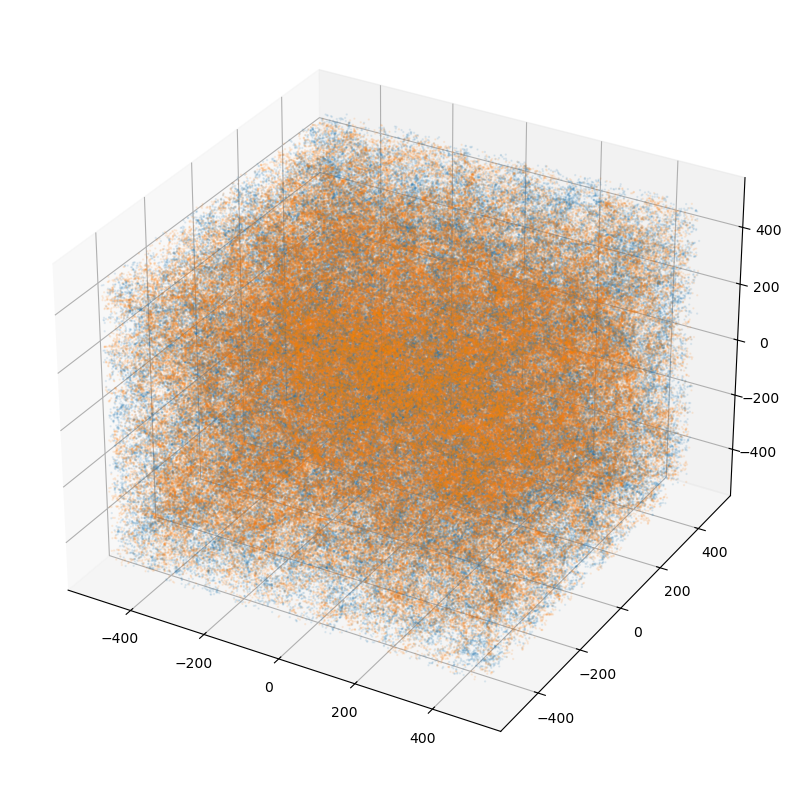

In [21]:
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection="3d"))
ax.scatter(halos.pos_x, halos.pos_y, halos.pos_z, s=2, marker=".", alpha=0.1)
ax.scatter(halos_.pos_x, halos_.pos_y, halos_.pos_z, s=2, marker=".", alpha=0.1)

In [22]:
one_axis = np.linspace(0, 1000, 256, endpoint=False)
y, x, z = np.meshgrid(one_axis, one_axis, one_axis)
centroids = np.c_[x.ravel(),y.ravel(),z.ravel()] + 1000/512

In [23]:
from scipy.spatial import cKDTree
tree = cKDTree(centroids, boxsize=1000)

In [25]:
dist, id = tree.query(np.c_[halos.pos_x, halos.pos_y, halos.pos_z] + 500)
dist_, id_ = tree.query(np.c_[halos_.pos_x, halos_.pos_y, halos_.pos_z] + 500)

In [ ]:
positions = (centroids - 500)

In [66]:
with h5py.File("./data/velocity_cic_0.hdf5", "r") as file:
    vpec = np.array(file["velocity_field_radial"])
    v_x = np.array(file["velocity_field_0"])
    v_y = np.array(file["velocity_field_1"])
    v_z = np.array(file["velocity_field_2"])
v = np.concatenate(
    [
        v_x.reshape(256, 256, 256, 1),
        v_y.reshape(256, 256, 256, 1),
        v_z.reshape(256, 256, 256, 1),
    ],
    axis=3,
)
with h5py.File("./data/velocity_cic_1.hdf5", "r") as file:
    vpec_ = np.array(file["velocity_field_radial"])
    v_x = np.array(file["velocity_field_0"])
    v_y = np.array(file["velocity_field_1"])
    v_z = np.array(file["velocity_field_2"])
v_ = np.concatenate(
    [
        v_x.reshape(256, 256, 256, 1),
        v_y.reshape(256, 256, 256, 1),
        v_z.reshape(256, 256, 256, 1),
    ],
    axis=3,
)

In [44]:
my_vpec = np.sum(positions[id]*v.reshape(-1, 3)[id], axis=1)/np.sqrt(np.sum(positions[id]**2, axis=1))
my_vpec_ = np.sum(positions[id_]*v_.reshape(-1, 3)[id_], axis=1)/np.sqrt(np.sum(positions[id_]**2, axis=1))

In [45]:
calc_vpec=np.sum(np.multiply(v.reshape(-1, 3)[id], positions[id]), axis=1)/np.linalg.norm(positions[id], ord=2, axis=1)
calc_vpec_=np.sum(np.multiply(v_.reshape(-1, 3)[id_], positions[id_]), axis=1)/np.linalg.norm(positions[id_], ord=2, axis=1)

In [48]:
halos['calc_vpec'] = calc_vpec
halos_['calc_vpec'] = calc_vpec_

In [72]:
halos.columns

Index(['Unnamed: 0', 'pos_x', 'pos_y', 'pos_z', 'vx', 'vy', 'vz', 'M200c',
       'halo_id', 'Rmax', 'd_c', 'vpec', 'z_cosmo', 'z', 'ra', 'dec',
       'calc_vpec'],
      dtype='object')

2025-03-20 16:36:33,013 WARNING Pandas support in corner is deprecated; use ArviZ directly
2025-03-20 16:36:35,899 WARNING Pandas support in corner is deprecated; use ArviZ directly


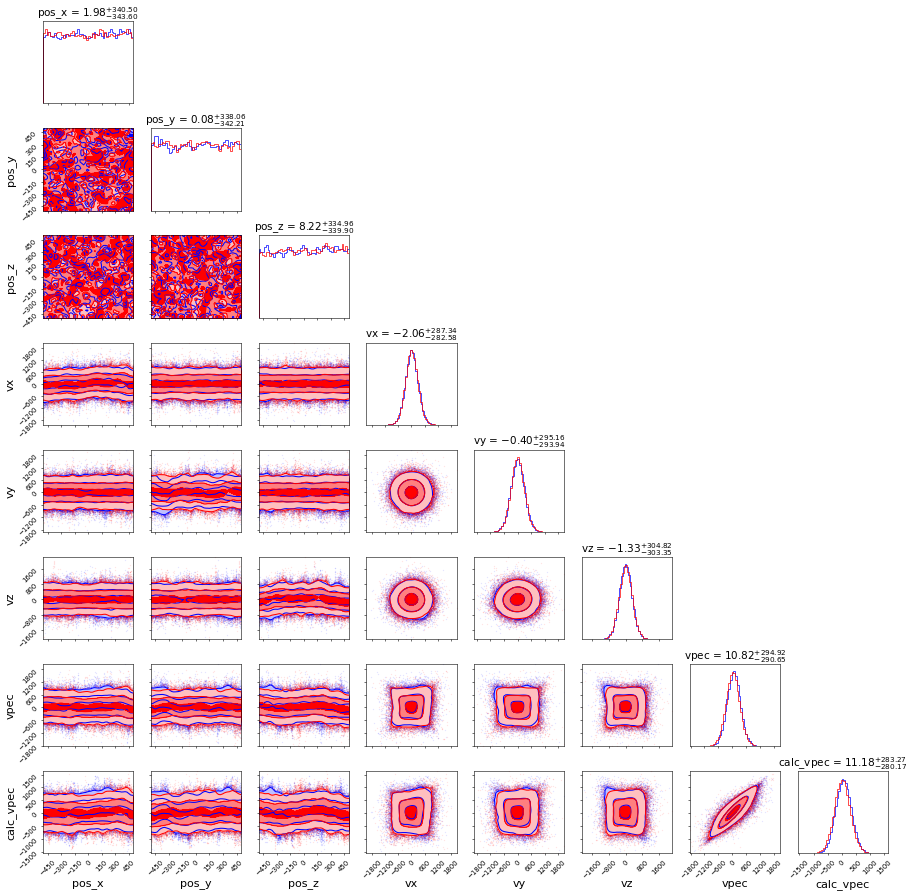

In [74]:
fig = corner_(halos, var_names=["pos_x", "pos_y", "pos_z", "vx", "vy", "vz", "vpec", "calc_vpec"], return_fig=True)
corner_(halos_, var_names=["pos_x", "pos_y", "pos_z", "vx", "vy", "vz", "vpec", "calc_vpec"], fig=fig, color='r')
plt.tight_layout()

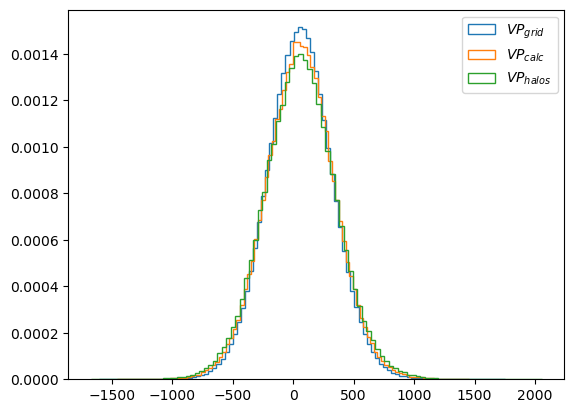

In [67]:
plt.hist(vpec.ravel(), bins=100, density=True, histtype="step", label=r"$VP_{grid}$")
_ = plt.hist(calc_vpec, bins=100, density=True, histtype="step", label=r"$VP_{calc}$")
_ = plt.hist(halos.vpec, bins=100, density=True, histtype="step", label=r"$VP_{halos}$")
plt.legend()


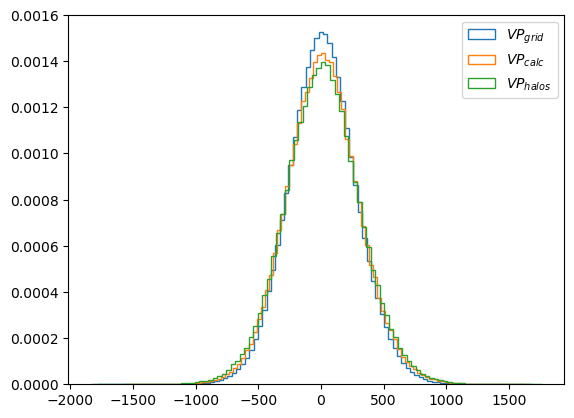

In [68]:
plt.hist(vpec_.ravel(), bins=100, density=True, histtype="step", label=r"$VP_{grid}$")
_ = plt.hist(calc_vpec_, bins=100, density=True, histtype="step", label=r"$VP_{calc}$")
_ = plt.hist(halos_.vpec, bins=100, density=True, histtype="step", label=r"$VP_{halos}$")
plt.legend()


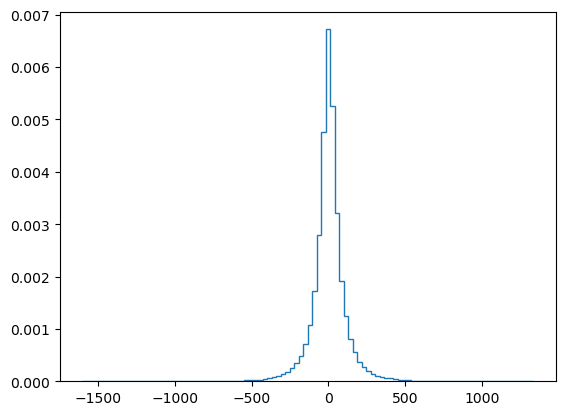

In [52]:
_ = plt.hist(calc_vpec - halos.vpec, bins=100, density=True, histtype="step", label=r"$VP_{calc} - VP_{halos}$")

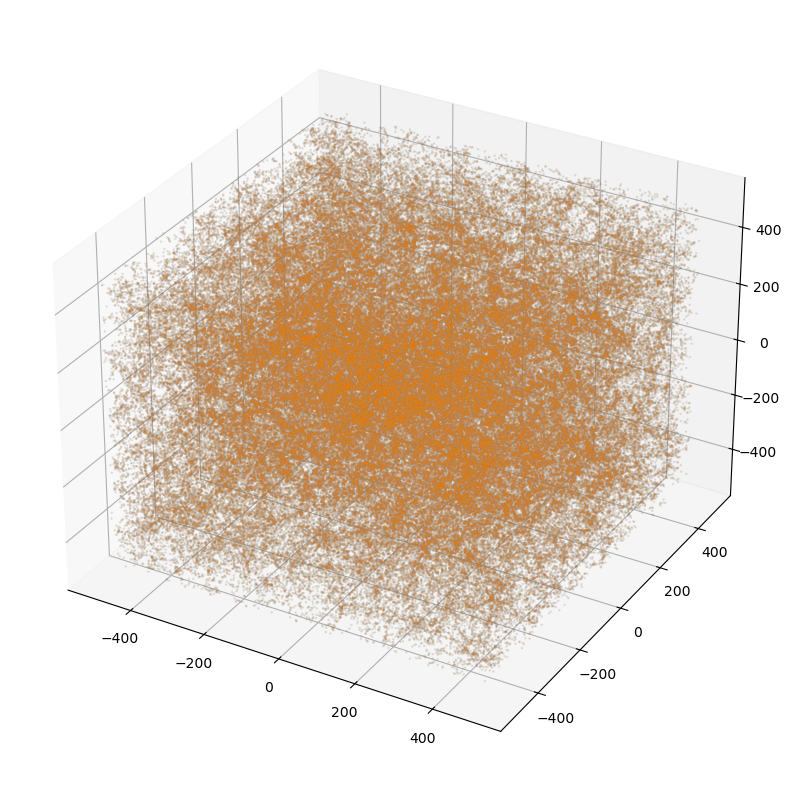

In [18]:
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection="3d"))
ax.scatter(*positions[id].T, s=2, marker=".", alpha=0.1)
ax.scatter(halos.pos_x, halos.pos_y, halos.pos_z, s=2, marker=".", alpha=0.1)

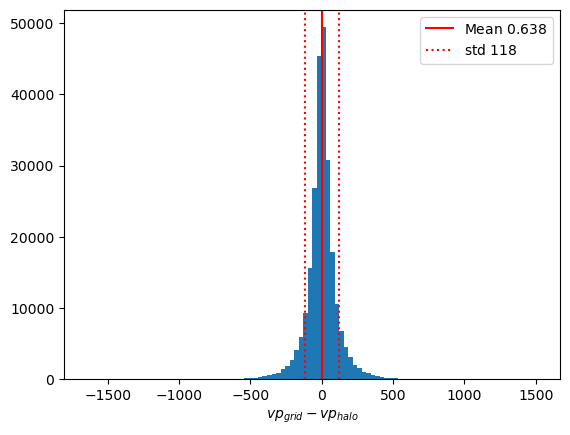

In [56]:
_=plt.hist(vpec.ravel()[id_] - halos_.vpec, bins=100)
mean, std = (vpec.ravel()[id_] - halos_.vpec).mean(), (vpec.ravel()[id_] - halos_.vpec).std()
plt.axvline(mean, color="r", label=rf'Mean ${mean:.3g}$')
plt.axvline(mean + std, color="r", linestyle=':', label=rf'std ${std:.3g}$')
plt.axvline(mean - std, color="r", linestyle=':')
plt.xlabel(r"$vp_{grid} - vp_{halo}$")
plt.legend()

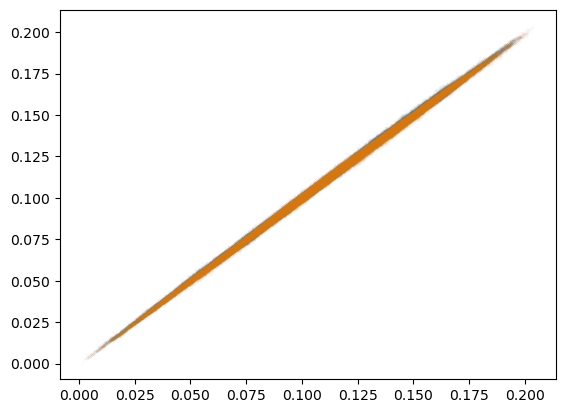

In [61]:
plt.scatter(halos.z_cosmo, halos.z, marker=".", s=0.1, alpha=0.1)
plt.scatter(halos_.z_cosmo, halos_.z, marker=".", s=0.1, alpha=0.1)

Text(0, 0.5, 'vpec')

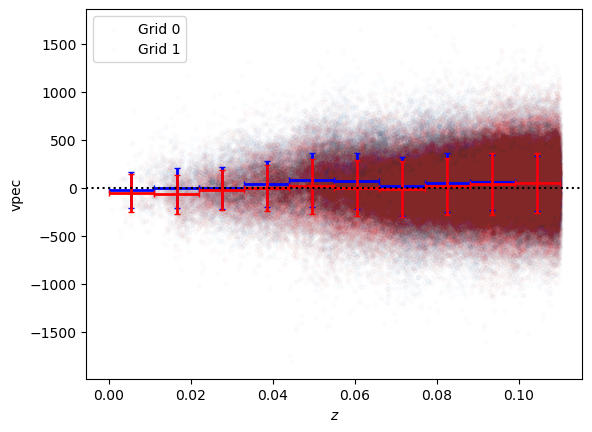

In [76]:
z_max = 0.11
n_bins = 10
width = z_max / n_bins
bounds = np.linspace(0, z_max - width, n_bins)

in_bins = [(halos.z > d_min) & (halos.z < d_min + width) for d_min in bounds]
in_bins_ = [(halos_.z > d_min) & (halos_.z < d_min + width) for d_min in bounds]
plt.scatter(
    halos.z[halos.z < z_max],
    halos.vpec[halos.z < z_max],
    marker=".",
    alpha=0.01,
    label="Grid 0",
)

plt.scatter(
    halos_.z[halos_.z < z_max],
    halos_.vpec[halos_.z < z_max],
    marker=".",
    color="tab:red",
    alpha=0.01,
    label="Grid 1",
)

plt.errorbar(
    bounds + width / 2,
    [halos.vpec[filt].mean() for filt in in_bins],
    yerr=[halos.vpec[filt].std() for filt in in_bins],
    xerr=width / 2,
    linestyle="",
    color="blue",
    linewidth=2,
    alpha=1,
    capsize=2,
)

plt.errorbar(
    bounds + width / 2,
    [halos_.vpec[filt].mean() for filt in in_bins_],
    yerr=[halos_.vpec[filt].std() for filt in in_bins_],
    xerr=width / 2,
    linestyle="",
    color="red",
    linewidth=2,
    alpha=1,
    capsize=2,
)

plt.axhline(0, color="k", linestyle=":")
plt.legend()
plt.xlabel(r'$z$')
plt.ylabel(r'vpec')


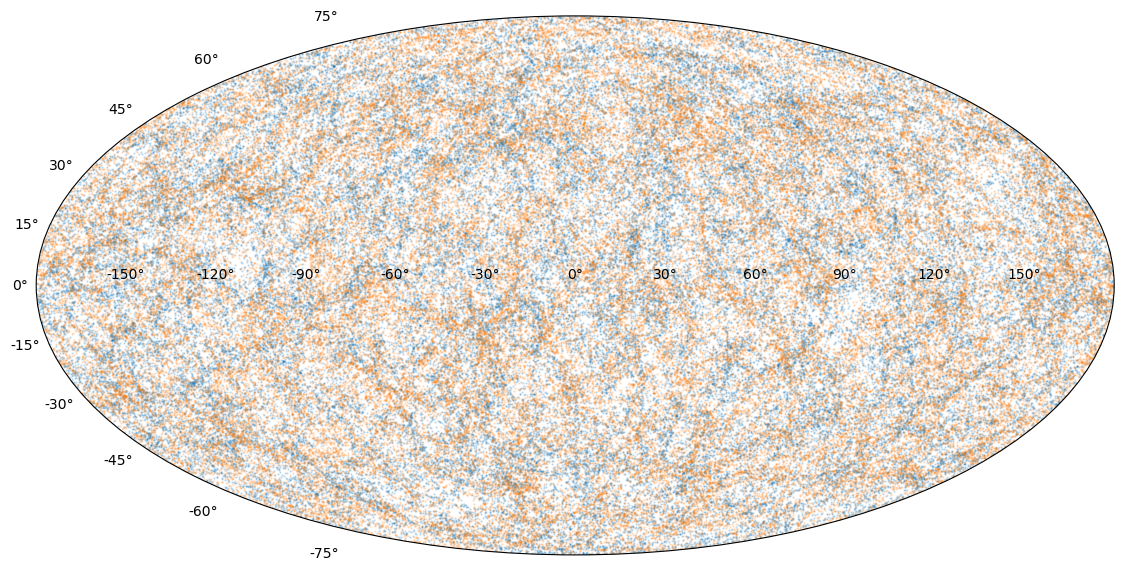

In [65]:
fig, ax = plt.subplots(figsize=(20, 7), subplot_kw=dict(projection="mollweide"))
ax.scatter(
    halos.ra[halos.z_cosmo < 0.1] * np.pi / 180,
    halos.dec[halos.z_cosmo < 0.1] * np.pi / 180,
    marker=".",
    s=2,
    alpha=0.2,
)
ax.scatter(
    halos_.ra[halos_.z_cosmo < 0.1] * np.pi / 180,
    halos_.dec[halos_.z_cosmo < 0.1] * np.pi / 180,
    marker=".",
    s=2,
    alpha=0.2,
)

## SNe Generation from 2M++

### ZTF

In [7]:
class SNeIa_full_bgs(Transient):

    _KIND = "SNIa"
    _RATE = 2.35 * 10**4 # /yr/Gpc^3 Perley 2020
    _COSMOLOGY = cosmo

    def __init__(self,
                 path=None,
                 filename="Uchuu.csv",
                 salt_path=None,
                 date_range=[58179, 59215],
                 zmax=0.06,
                 extinction=True):
        super().__init__()
        # {'model': func, 'prop': dict, 'input':, 'as':}
        self.galaxy_positions = load_bgs(path=path, filename=filename)
        self.set_model(dict(
            x1={"func": SNeIaStretch.nicolas2021},
            c={"func": SNeIaColor.intrinsic_and_dust},
            t0={"func": np.random.uniform, "kwargs": {"low": date_range[0], "high": date_range[1]}},
            magabs={
                "func": SNeIaMagnitude.tripp1998,
                "kwargs": {"x1": "@x1", "c": "@c", "mabs": -19.3, "sigmaint": 0.10},
            },
            magobs={
                "func": "magabs_to_magobs",  # defined in Target (mother of Transients)
                "kwargs": {"z": "@z_cosmo", "magabs": "@magabs"},
            },
            x0={
                "func": "magobs_to_amplitude",  # defined in Transients
                "kwargs": {"magobs": "@magobs", "param_name": "x0"},
            },  # because it needs to call sncosmo_model.get(param_name)
            radecz={
                "func": rand_positions,
                "kwargs": {"positions": self.galaxy_positions, 'zcut': zmax},
                "as": ["ra", "dec", "z", "bgs_id", "z_cosmo"],
            },
        ))
        
        if salt_path:
            source = sncosmo.SALT2Source(modeldir=salt_path,
                                         m0file='nacl_m0_test.dat',
                                         m1file='nacl_m1_test.dat',
                                         clfile='nacl_color_law_test.dat')
        else:
            source = sncosmo.get_source('salt2', version='2.4')
        
        if extinction:
            model = sncosmo.Model(source=source, effects=[sncosmo.CCM89Dust()], effect_names=['mw'], effect_frames=['obs'])
            self.set_model({**self.model.model,
                            "mwebv":{"func": milkyway.get_mwebv, "kwargs": {"ra": "@ra", "dec": "@dec"}},})
        else:
            model= sncosmo.Model(source=source)
        self.set_template(model)
        
        self.area=self.get_effective_area()
        # USE THIS AREA WHEN DRAWING TO ACCOUNT FOR THE CATALOG FOOTPRINT
        # e.g. SNeIa_full_bgs().draw(skyarea=SNeIa_full_bgs().area)

    def get_effective_area(self):
        nside = 2**(np.int32(np.log2(np.sqrt(self.galaxy_positions.shape[0]/(10*12))))-1)
        id_bgs = ang2pix(theta=np.pi / 2 - self.galaxy_positions["dec"] * np.pi / 180,
                            phi=self.galaxy_positions["ra"] * np.pi / 180,
                            nside=nside)

        mask = np.zeros(nside2npix(nside), dtype=bool)
        for i in id_bgs:
            mask[i] = True

        return np.sum(mask)*nside2pixarea(nside, degrees=True)


In [8]:
survey=extract_ztf()

snia = SNeIa_full_bgs(filename="/cfs/home/angi0819/Projet-LPNHE/Projet-LPNHE/data/2M++_subhalo_0.csv",
                      date_range=survey.date_range,
                      zmax=0.1,)
# snia.cosmology=cosmo
_ = snia.draw(tstart=survey.date_range[0], tstop=survey.date_range[1],
              zmax=0.1,
              skyarea=snia.area,
              inplace=True)

2025-03-17 13:39:07 INFO ZTFxUchuu - Loading ZTF survey
2025-03-17 13:39:24 INFO ZTFxUchuu - Found .csv file at /cfs/home/angi0819/Projet-LPNHE/Projet-LPNHE/data/2M++_subhalo_0.csv with columns Index(['pos_x', 'pos_y', 'pos_z', 'vx', 'vy', 'vz', 'M200c', 'halo_id', 'Rmax',
       'd_c', 'vpec', 'z_cosmo', 'z', 'ra', 'dec'],
      dtype='object')
2025-03-17 13:39:24 WARNING py.warnings - /cfs/home/angi0819/conda/0.2/envs/georges/lib/python3.12/site-packages/skysurvey/target/core.py:1001: UserWarning: skyarea given but no model have skyarea as parameters. This is ignored.
  warnings.warn("skyarea given but no model have skyarea as parameters. This is ignored.")



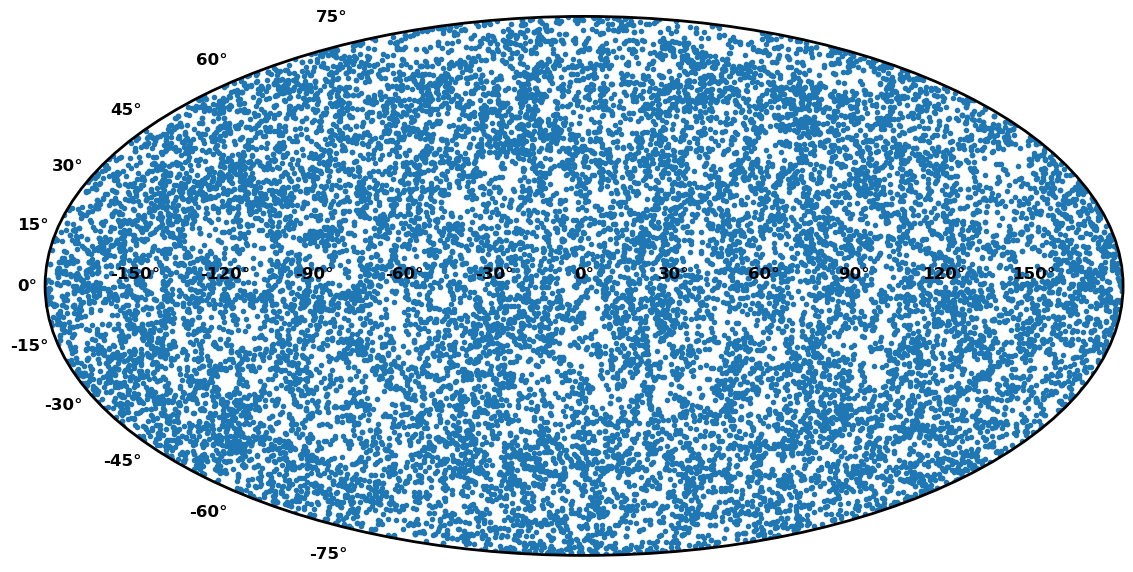

In [9]:
fig, ax = plt.subplots(figsize=(20,7), subplot_kw=dict(projection="mollweide"))
plt.scatter(snia.data.ra*np.pi/180, snia.data.dec*np.pi/180, marker='.')

In [11]:
dset = skysurvey.DataSet.from_targets_and_survey(snia, survey, incl_error=True)

2025-03-17 13:43:35 WARNING py.warnings - /cfs/home/angi0819/conda/0.2/envs/georges/lib/python3.12/site-packages/ztffields/projection.py:157: UserWarning: cannot use dask_geopandas with MultiIndex fields dataframe
  warnings.warn("cannot use dask_geopandas with MultiIndex fields dataframe")



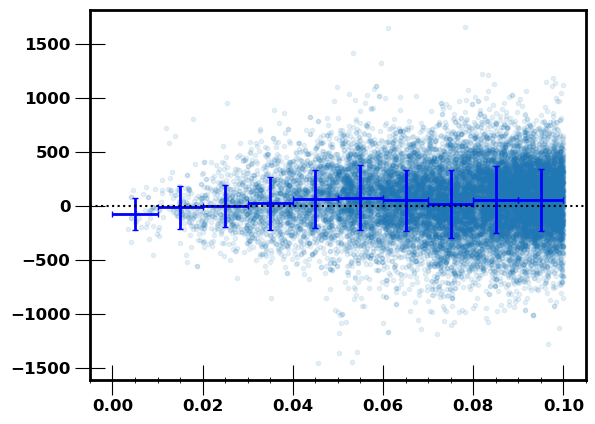

In [12]:
z_max = 0.1
n_bins = 10
width = z_max/n_bins
bounds = np.linspace(0.00, z_max-width, n_bins)
pv = (dset.targets.data.z - dset.targets.data.z_cosmo)*1e-3*c/(1+dset.targets.data.z_cosmo)
in_bins = [(dset.targets.data.z > z_min) & (dset.targets.data.z < z_min + width) for z_min in bounds]
plt.scatter(dset.targets.data.z,
            pv,
            marker=".",
            alpha=0.1,
           )


plt.errorbar(bounds + width/2,
             [pv[filt].mean() for filt in in_bins],
             yerr=[pv[filt].std() for filt in in_bins],
             xerr=width/2,
             linestyle='',
             color='blue',
             linewidth=2,
             alpha=1,
             capsize=2)
plt.axhline(0, color="k", linestyle=":")

In [32]:
dset.data.rename(columns={"mjd":"time"}, inplace=True)


In [33]:
with open('/cfs/data/angi0819/Projet_LPNHE/dataset_2M++.pkl', 'wb') as file:
    pickle.dump(dset.targets.data, file)
    pickle.dump(dset.data.rename(columns={'mjd':'time'}), file)

In [7]:
with open('/cfs/data/angi0819/Projet_LPNHE/dataset_2M++.pkl', 'rb') as file:
    data = pickle.load(file)
    lc = pickle.load(file)

2025-03-11 13:48:37 INFO ZTFxUchuu - Loading ZTF survey
2025-03-11 13:48:45 INFO ZTFxUchuu - Found .csv file at /cfs/home/angi0819/Projet-LPNHE/Projet-LPNHE/data/2M++_subhalo_0.csv with columns Index(['pos_x', 'pos_y', 'pos_z', 'vx', 'vy', 'vz', 'M200c', 'halo_id', 'Rmax',
       'd_c', 'vpec', 'z_cosmo', 'z', 'ra', 'dec'],
      dtype='object')


2025-03-17 13:56:03 WARNING root - Pandas support in corner is deprecated; use ArviZ directly


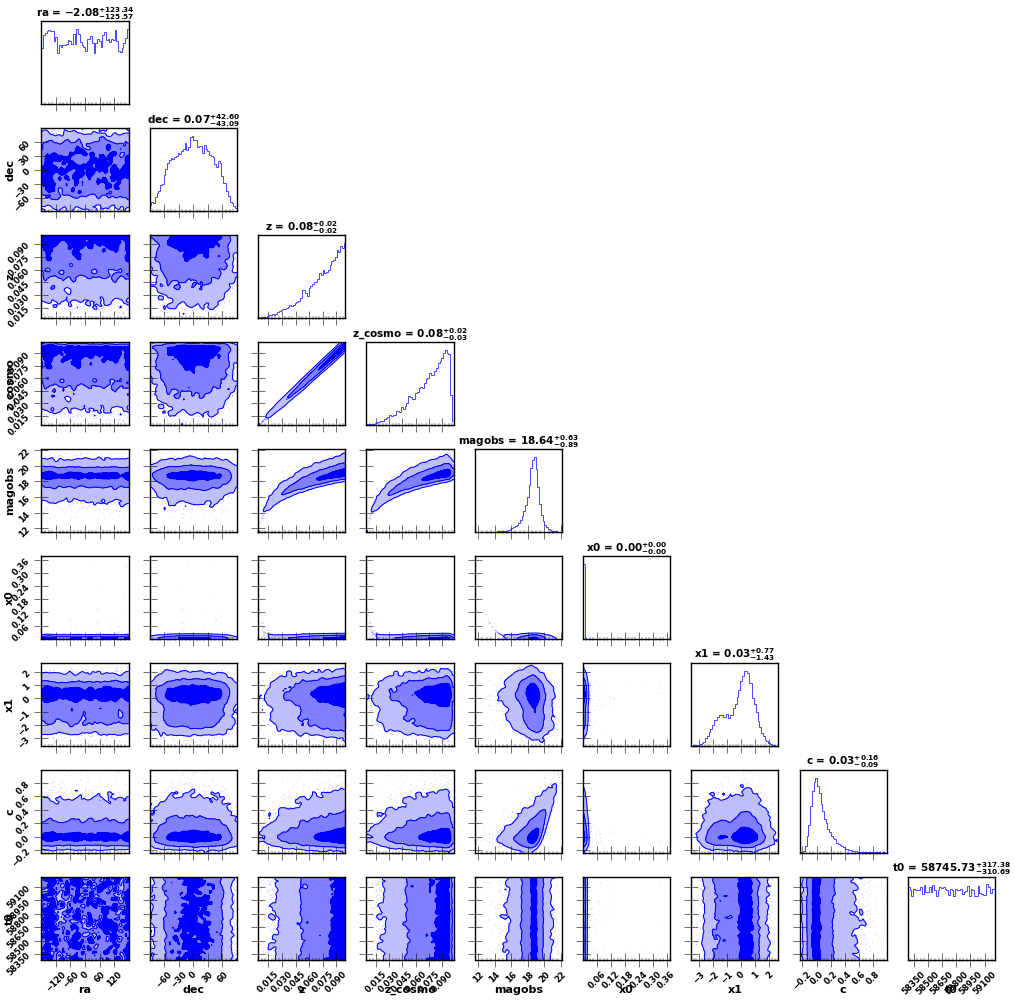

In [31]:
_=corner_(dset.targets.data, var_names=["ra","dec","z","z_cosmo","magobs","x0","x1","c","t0"])
plt.tight_layout()

### HSC/SNLS

In [8]:
class SNeIa( skysurvey.SNeIa ):

    _COSMOLOGY=cosmo
    
snia = SNeIa()


In [22]:
survey = extract_hsc()

2025-03-17 14:32:03 WARNING py.warnings - /cfs/home/angi0819/conda/0.2/envs/georges/lib/python3.12/site-packages/skysurvey/survey/polygon.py:167: UserWarning: You do not have polars installed. conda/pip install polars. falling back to pandas backend
  warnings.warn("You do not have polars installed. conda/pip install polars. falling back to pandas backend")



In [23]:
from skysurvey.effects.milkyway import mwebv_model
snia.update_model(t0={"func":np.random.uniform,
                      'kwargs':{'low':survey.date_range[0], 'high':survey.date_range[1]}}, 
                  redshift={"kwargs": {'zmax': 1.6,}, 'as':'z'},
                  **mwebv_model)

In [24]:
snia.draw(tstart=survey.date_range[0], tstop=survey.date_range[1],
          skyarea=survey.get_skyarea().buffer(0.01), zmax=1.6,
          inplace=True)

z     x1      c            t0          ra       dec     magabs  \
0      1.16905 -0.055 -0.037  58168.343750   34.763477 -4.637465 -19.334597   
1      0.71985 -0.385  0.237  59332.386719   35.636395 -4.407092 -18.402191   
2      1.40465  0.580  0.175  59597.789062  151.700851  1.332501 -18.989885   
3      1.13285 -0.310  0.015  59342.468750   33.969597 -5.160699 -19.056999   
4      0.81755  1.045 -0.010  57814.820312  149.430801  2.913926 -19.463724   
...        ...    ...    ...           ...         ...       ...        ...   
23868  1.10935 -1.845  0.025  59083.867188  149.676682  2.842216 -19.103029   
23869  0.57185 -0.365  0.037  59357.328125  149.655792  1.981150 -19.126860   
23870  0.90345  0.800 -0.120  59762.128906  149.157379  3.450848 -19.831032   
23871  1.59155  0.775  0.056  58617.480469   36.278728 -4.832469 -19.240152   
23872  1.39895 -0.110 -0.073  58642.015625  149.805618  1.497939 -19.541115   

          mwebv     magobs            x0 template  
0      0.025897  25.236488  1.276585e-06    salt2  
1      0.033165  24.872707  1.784685e-06    salt2  
2      0.035697  26.073372  5.906030e-07    salt2  
3      0.026192  25.429722  1.068454e-06    salt2  
4      0.029470  24.149885  3.472890e-06    salt2  
...         ...        ...           ...      ...  
23868  0.022407  25.327473  1.173966e-06    salt2  
23869  0.024556  23.540384  6.088227e-06    salt2  
23870  0.028909  24.049446  3.809487e-06    salt2  
23871  0.035435  26.157295  5.466721e-07    salt2  
23872  0.025875  25.511253  9.911595e-07    salt2  

[23873 rows x 11 columns]

In [25]:
dset = skysurvey.DataSet.from_targets_and_survey(snia, survey, discard_bands=True)

2025-03-17 14:32:08 WARNING py.warnings - /cfs/home/angi0819/conda/0.2/envs/georges/lib/python3.12/site-packages/skysurvey/dataset.py:683: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  this_survey = gsurvey_indexed.get_group(index_).copy()



In [26]:
dset.data.rename(columns={"mjd":"time"}, inplace=True)

In [ ]:
with open('/cfs/data/angi0819/Projet_LPNHE/dataset_hsc.pkl', 'wb') as file:
    pickle.dump(dset.targets.data, file)
    pickle.dump(dset.data.rename(columns={'mjd':'time'}), file)

### Spectra

In [58]:
data, lc = load_from_skysurvey("/cfs/data/angi0819/Projet_LPNHE/dataset_snls.pkl", survey='SNLS')

In [59]:
lc = lc[(lc.time.between(data.loc[lc.name, 't0'] - 50, data.loc[lc.name, 't0'] + 100))].copy()
lc['valid'] = (lc.flux/lc.fluxerr>5)

In [60]:
# Select SN on : >=5 detections in >=2 bands
goods_sn = (lc[lc.valid].groupby(["name"]).band.nunique() >= 2) & \
           (lc[lc.valid].groupby(["name"])['flux'].count() >= 5) & \
           (lc[lc.valid][lc[lc.valid].time < data.loc[lc[lc.valid].name, "t0"]].groupby("name").flux.count() >= 2) & \
           (lc[lc.valid][lc[lc.valid].time > data.loc[lc[lc.valid].name, "t0"]].groupby("name").flux.count() >= 2)

In [61]:
lc = lc[lc.name.isin(goods_sn[goods_sn].index)]

data = data[data.name.isin(lc.name.unique())]

In [62]:
snia = skysurvey.SNeIa.from_data(data)
snia.update_model(#t0={"func":np.random.uniform, 'kwargs':{'low':survey.date_range[0], 'high':survey.date_range[1]}},
                  redshift={"kwargs": {'zmax':1.6,}, 'as':'z'},
                  mwebv={"func": skysurvey.effects.milkyway.get_mwebv, "kwargs": {"ra": "@ra", "dec": "@dec"}},)

source = sncosmo.get_source('salt2', version='2.4')
model= sncosmo.Model(source=source,effects=[sncosmo.CCM89Dust()],effect_names=['mw'],effect_frames=['obs'])

snia.set_template(model)

In [63]:
output = lc.loc[data.index].join(data.drop(columns=["sn", "survey", "name"])).drop(columns=['template'])
output['snid'] = output.index

In [64]:
from mocksurvey.simulations import (
    get_luminosity_distance,
    get_effective_wavelength,
    get_snr,
    build_band_index,
    discard_small_snr,
    discard_skysurvey_flux,
    eliminate_points_not_in_model,
    get_trueflux_and_amplitude,
    get_sn_position,
)

output = get_luminosity_distance(output, snia)
output = get_effective_wavelength(output)

output = eliminate_points_not_in_model(output, snia)
output.to_csv("./outdir/mock_survey.csv", index=False)

2025-03-17 14:37:38 INFO root - Getting luminosity distances in Mpc
2025-03-17 14:37:38 INFO root - Getting effective wavelengths
2025-03-17 14:37:38 INFO root - Eliminating points not in model


In [65]:
output = get_trueflux_and_amplitude(output, snia)

2025-03-17 14:37:45 INFO root - Getting true fluxes and amplitudes


In [66]:
output = get_snr(output)

2025-03-17 14:37:54 INFO root - Getting snr


In [67]:
output = discard_small_snr(output, threshold=0)

2025-03-17 14:38:02 INFO root - Discarding small snr
2025-03-17 14:38:02 INFO root - Getting SN indexes


In [68]:
output = discard_skysurvey_flux(output)

2025-03-17 14:38:02 INFO root - Discarding skysurvey flux


In [ ]:
def plot_lc_index(index, lc_data, sne_data=None):
    """
    My plotting for lightcurve because I was tired of having to put everything in a skysurvey dataset.
    """
    if sne_data is not None:
        model.set(z=sne_data.loc[index, 'z'],
                  x0=sne_data.loc[index, 'x0'],
                  x1=sne_data.loc[index, 'x1'],
                  c=sne_data.loc[index, 'c'],
                  mwebv=sne_data.loc[index, 'mwebv'],
                  mwr_v=3.1,t0=0)  # set the model's redshift and MW

        if "tmax" in sne_data.columns:
            t0 = sne_data.loc[index, "tmax"]
            err_t0 = sne_data.loc[index, "err_tmax"]
            plt.axvline(t0, color="r", label=r"$t_0$")
            plt.axvline(t0 - err_t0, color="r", linestyle=":")
            plt.axvline(t0 + err_t0, color="r", linestyle=":")
        else:
            t0 = sne_data.loc[index, "t0"]
            plt.axvline(t0, color="r", label=r"$t_0$")

    for b in np.unique(lc_data[(lc_data.name==index) & (lc_data.valid==1)].band):
        lc = lc_data[(lc_data.band==b) & (lc_data.name==index)].sort_values(by='mjd')
        coef = 10 ** (-(lc["zp"] - 25) / 2.5)
        plt.errorbar(lc["mjd"],
                     lc["flux"]*coef,
                     yerr=lc["fluxerr"]*coef,
                     linestyle='',
                     marker='.',
                     color=color_band[b],
                     label=b
                    )
        if sne_data is not None:
            times = np.linspace(-20, 50, 1000)
            plt.plot(times+t0, model.bandflux(b, times, zp=25, zpsys="AB"), color=color_band[b])

        
    plt.title(f"SN {index}")
    plt.legend()



In [ ]:
output = get_sn_position(output)

2025-03-17 14:38:02 INFO root - Adding (x, y) positions of the SN


In [70]:
output.to_csv("./outdir/mock_survey.csv", index=False)

In [71]:
output=pandas.read_csv('./outdir/mock_survey.csv')

In [72]:
def f(x, a, b, c):
    """ """
    return a * x**2 + b * x + c
data_sim = []

idx = output["fluxtrue"] != 0
output = output[idx]

mock_snid = np.unique(output["snid"])

length_wave = np.array([218, 437, 3258, 656, 868])
popt = np.array([-7.87649259e-07, 1.08382223e-02, -2.44390307e01])
a, b, c = popt

In [73]:
for i,snid in tqdm(enumerate(mock_snid), total=len(mock_snid)):
    try:
        mock_sn = output[output["snid"] == snid]
        x0 = mock_sn.iloc[0]["x0"]
        x1 = mock_sn.iloc[0]["x1"]
        c = mock_sn.iloc[0]["c"]
        t0 = mock_sn.iloc[0]["t0"]
        z = mock_sn.iloc[0]["z"]
        mwebv = mock_sn.iloc[0]["mwebv"]
        
        wave_size = np.random.choice(length_wave)
        min_wave = np.random.uniform(2900.0, 3400.0)
        max_wave = np.random.uniform(9000.0, 11000.0)
        wavelength = np.linspace(min_wave, max_wave, wave_size)
        
        
        mjd = np.random.choice(mock_sn["time"][mock_sn["time"].between(t0 - 10, t0 + 40)])
        
        source = sncosmo.get_source('salt2', version='2.4')
        model= sncosmo.Model(source=source,effects=[sncosmo.CCM89Dust()],effect_names=['mw'],effect_frames=['obs'])
        p = {"z": z, "t0": t0, "x0": x0, "x1": x1, "c": c, "mwebv": mwebv, "mwr_v": 3.1}
        model.set(**p)
        
        min_w = model.minwave()
        max_w = model.maxwave()
        
        try:
            flux_true = model.flux(mjd, wavelength)
        except:
            try:
                wavelength = wavelength[wavelength < model.maxwave()]
                flux_true = model.flux(mjd, wavelength)
            except:
                wavelength = wavelength[wavelength > model.minwave()]
                flux_true = model.flux(mjd, wavelength)
        
        norm_values = np.array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1e12])
        norm = np.random.choice(norm_values)
        flux_true *= norm
        flux_err = (flux_true / f(wavelength, a, b, c)) * np.random.randn(
            len(flux_true)
        )
        flux = flux_true + 0.5 * flux_err
        
        spec_sim = pandas.DataFrame(columns=["spec","time","wavelength","flux","fluxerr","valid","exptime","snid","flux_true","x0","x1","c","t0","mwebv","z"],
                                   dtype=('int','float'))
        spec_sim['wavelength'] = wavelength
        spec_sim['flux'] = flux
        spec_sim['flux_true'] = flux_true
        spec_sim['fluxerr'] = np.abs(flux_err)
        spec_sim['time'] = mjd
        spec_sim['valid'] = 1
        spec_sim['exptime'] = np.nan
        spec_sim['sn'] = mock_sn.iloc[0]["sn"]
        spec_sim['snid'] = snid
        spec_sim['spec'] = i
        spec_sim["z"] = z
        spec_sim["x0"] = x0
        spec_sim["x1"] = x1
        spec_sim["c"] = c
        spec_sim["t0"] = t0
        spec_sim["mwebv"] = mwebv
        data_sim.append(spec_sim)
    except ValueError as e:
        logging.info(f"No spectra could be generated for the sn {mock_sn.iloc[0]['sn']}")
        continue
spec = pandas.concat(data_sim)

  0%|          | 0/957 [00:00<?, ?it/s]

In [74]:
spec.to_csv("/cfs/data/angi0819/Projet_LPNHE/spectra_snls.csv", index=False)

### TDS

In [74]:
data_ztf, lc_ztf = load_from_skysurvey("/cfs/data/angi0819/Projet_LPNHE/dataset_2M++.pkl", survey='ZTF')
data_hsc, lc_hsc = load_from_skysurvey("/cfs/data/angi0819/Projet_LPNHE/dataset_hsc.pkl", survey='HSC')
data_snls, lc_snls = load_from_skysurvey("/cfs/data/angi0819/Projet_LPNHE/dataset_snls.pkl", survey='SNLS')

In [75]:
spec_ztf = pandas.read_csv("/cfs/data/angi0819/Projet_LPNHE/spectra_2M++.csv").drop(columns=['x0','x1','c','t0','mwebv','z','flux_true','snid'])
spec_ztf['survey'] = 'ZTF'
spec_hsc = pandas.read_csv("/cfs/data/angi0819/Projet_LPNHE/spectra_hsc.csv").drop(columns=['x0','x1','c','t0','mwebv','z','flux_true','snid'])
spec_hsc['survey'] = 'HSC'
spec_snls = pandas.read_csv("/cfs/data/angi0819/Projet_LPNHE/spectra_snls.csv").drop(columns=['x0','x1','c','t0','mwebv','z','flux_true','snid'])
spec_snls['survey'] = 'SNLS'
shift_sp_ztf, shift_sp_snls = spec_ztf.spec.max()+1, spec_snls.spec.max()+1
spec_snls.spec += shift_sp_ztf
spec_hsc.spec += shift_sp_ztf + shift_sp_snls

In [76]:
data = pandas.concat([data_ztf, data_snls, data_hsc])
lc = pandas.concat([lc_ztf, lc_snls, lc_hsc])
spec = pandas.concat([spec_ztf, spec_snls, spec_hsc])
spec['name'] = spec.survey + '_' + spec.sn.astype(str)
spec.set_index('name', drop=False, inplace=True)

In [77]:
# Select only points at 5 sigma and in [tmax-50, tmax+100]
lc = lc[(lc.flux/lc.fluxerr>5) &
                (lc.time.between(data.loc[lc.name, 't0'] - 50,
                                     data.loc[lc.name, 't0'] + 100))].copy()

# Select SN on : >=5 detections in >=2 bands
goods_sn = (lc.groupby(["name"]).band.nunique() >= 2) & \
           (lc.groupby(["name"])['flux'].count() >= 5) & \
           (lc[lc.time < data.loc[lc.name, "t0"]].groupby("name").flux.count() >= 2) & \
           (lc[lc.time > data.loc[lc.name, "t0"]].groupby("name").flux.count() >= 2)


In [78]:
lc = lc[goods_sn.loc[lc.name]]
data = data[data.name.isin(lc.name.unique())]
spec = spec[spec.name.isin(lc.name.unique())]

In [79]:
lc_dtype=np.dtype([
    ('sn', 'O'), ('mjd', '<f8'), ('flux', '<f8'), ('fluxerr', '<f8'),
    ('band', 'O'), ('magsys', 'O'), ('exptime', '<f8'), ('valid', '<i8'),
    ('lc', 'O'), ('zp', '<f8'), ('mag_sky', '<f8'), ('seeing', '<f8'),
    ('x', '<f8'),('y', '<f8'), ('sensor_id', '<i8')])

N = len(lc)
lc_rec = np.recarray((N), dtype=lc_dtype)
lc_rec["sn"] = lc.name
lc_rec["mjd"] = lc.time
lc_rec["flux"] = lc.flux
lc_rec["fluxerr"] = lc.fluxerr
lc_rec["band"] = lc.band
lc_rec["zp"] = lc.zp
lc_rec["magsys"] = lc.zpsys
lc_rec["valid"] = np.ones(N)
lc_rec["lc"] = lc_rec["sn"] + "_" + lc_rec["band"]

In [80]:
sn_dtype=np.dtype([
    ('sn', 'O'), ('z', '<f8'), ('tmax', '<f8'), ('x1', '<f8'),
    ('x0', '<f8'), ('c', '<f8'), ('mwebv', '<f8'), ('valid', '<i8'), ('IAU', 'O'), ('survey', 'O')])

N = len(data)
sn_rec = np.recarray((N), dtype=sn_dtype)
sn_rec["sn"] = data.name
sn_rec["z"] = data.z
sn_rec["x0"] = data.x0
sn_rec["x1"] = data.x1
sn_rec["c"] = data.c
sn_rec["tmax"] = data.t0
sn_rec["mwebv"] = data.mwebv
sn_rec["valid"] = np.ones(N)
sn_rec["survey"] = data.survey


In [81]:
sp_dtype = np.dtype([
        ('sn', 'O'),
        ('mjd', '<f8'),
        ('wavelength', '<f8'),
        ('flux', '<f8'),
        ('fluxerr', '<f8'),
        ('i_basis', '<i8'),
        ('valid', '<i8'),
        ('spec', '<i8'),
        ('exptime', '<f8'),])
N = len(spec)
spec_rec = np.recarray((N), dtype=sp_dtype)

spec_rec['sn'] = spec.name
spec_rec['mjd'] = spec.time
spec_rec['wavelength'] = spec.wavelength
spec_rec['flux'] = spec.flux
spec_rec['fluxerr'] = spec.fluxerr
spec_rec['i_basis'] = np.zeros(N)
spec_rec['valid'] = spec.valid
spec_rec['spec'] = spec.spec
spec_rec['exptime'] = spec.exptime

In [82]:
tds = TrainingDataset(sn_rec, lc_data=lc_rec, spec_data=spec_rec, filterlib=filterlib)

2025-03-19 11:54:50 INFO nacl.dataset - indexing light curves
2025-03-19 11:54:51 INFO nacl.dataset - indexing spectra


In [97]:
tds.kill_sne(tds.sn_data.sn[tds.sn_data.z > 0.6])

In [98]:
tds.compress()

2025-03-19 11:58:41 INFO nacl.dataset - indexing light curves
2025-03-19 11:58:42 INFO nacl.dataset - indexing spectra


In [101]:
tds.to_parquet('tds_z0_6', path="./data/")

In [102]:
from minipets import Dataset as PetsDataset
pets_tds = PetsDataset.from_nacl(tds)
pets_tds.dr2_like_cuts()
pets_tds.apply_cut()
pets_tds.get_tds().to_parquet('tds_z0_6_dr2_cuts', path="./data/")

2025-03-19 12:00:56 INFO lemaitre.bandpasses.flibs - loading lemaitre filterlib from /cfs/home/angi0819/.cache/bbf/lemaitre_flib.default.8b60dc74f159a054b89823bf69268619b44dc7e72cdf1dfe92e5c1d6c641d4d2.pkl
2025-03-19 12:00:58 INFO nacl.dataset - indexing light curves
2025-03-19 12:00:58 INFO nacl.dataset - indexing spectra
2025-03-19 12:01:06 INFO minipets.dataset - removing 0 SNe with less than 2 bands: []
2025-03-19 12:01:08 INFO nacl.dataset - indexing light curves
2025-03-19 12:01:08 INFO nacl.dataset - indexing spectra
2025-03-19 12:01:15 INFO root - removing 90 SNe with less than 5 points: ['HSC_22405' 'ZTF_13315' 'HSC_9334' 'ZTF_18632' 'HSC_22121' 'ZTF_11119'
 'ZTF_15151' 'ZTF_4399' 'ZTF_7434' 'ZTF_13645' 'ZTF_14520' 'ZTF_12033'
 'ZTF_15972' 'SNLS_4939' 'ZTF_5843' 'ZTF_9025' 'ZTF_9987' 'ZTF_9664'
 'ZTF_2544' 'ZTF_1608' 'ZTF_4196' 'HSC_14184' 'SNLS_7109' 'ZTF_18986'
 'ZTF_5491' 'ZTF_12158' 'ZTF_11582' 'ZTF_19792' 'ZTF_14731' 'ZTF_5321'
 'ZTF_2584' 'SNLS_3' 'ZTF_5227' 'ZTF_340' 'Z

### Trainer

In [104]:
from nacl.tools import NaClTrainer
trainer = NaClTrainer('./data/tds_z0_6_dr2_cuts', '/cfs/data/angi0819/Projet_LPNHE/test/')

2025-03-19 12:02:31 INFO lemaitre.bandpasses.flibs - loading lemaitre filterlib from /cfs/home/angi0819/.cache/bbf/lemaitre_flib.default.8b60dc74f159a054b89823bf69268619b44dc7e72cdf1dfe92e5c1d6c641d4d2.pkl
2025-03-19 12:02:33 INFO nacl.dataset - indexing light curves
2025-03-19 12:02:34 INFO nacl.dataset - indexing spectra
2025-03-19 12:02:40 INFO nacl.models.salt2.salt - default regular grid in wavelength
2025-03-19 12:02:40 INFO nacl.models.salt2.salt - user provided grid in phase
2025-03-19 12:02:40 INFO nacl.models.salt2.salt - initializing lightcurve eval unit
2025-03-19 12:02:42 WARNING py.warnings - /cfs/home/angi0819/conda/0.2/envs/georges/lib/python3.12/site-packages/dust_extinction/helpers.py:30: UserWarning: x has no units, assuming x units are inverse microns
  warnings.warn(

2025-03-19 12:02:46 INFO nacl.models.salt2.salt - initializing spectrum eval unit
2025-03-19 12:03:03 INFO nacl.models.salt2.salt - user provided grid in wavelength
2025-03-19 12:03:03 INFO nacl.model

In [ ]:
v_init = trainer.model_initial(trainer.pars_initial)


In [ ]:
color_band = {"ztfi":"olive",
             "ztfr":"purple",
             "ztfg":"limegreen",
             "megacam6::z":"blue",
             "megacam6::r":"red",
             "megacam6::g":"green",
             "megacam6::i2":"orange",
             "hsc::Y":"turquoise",
             "hsc::g":"olivedrab",
             "hsc::i2":"gray", 
             "hsc::r2":"darkred",
             "hsc::z":"gold",
             }


In [ ]:
plt.figure(figsize=(20,20))
for b in np.unique(trainer.tds.lc_data.nt.band):
    plt.scatter(trainer.tds.lc_data.flux[trainer.tds.lc_data.band == b],
                v_init[:len(trainer.tds.lc_data.nt)][trainer.tds.lc_data.band == b],
                s=2,
           color=color_band[b], label=b)
plt.legend()
plt.loglog(*[[1e1, 1e6]]*2, ':k')


In [105]:
from nacl.models.salt2 import DustExtinction
trainer.model_initial = SALT2Like(trainer.tds,
                            phase_grid=np.linspace(-50, 100., 150),
                            dust_extinction_model=DustExtinction().CCM89_dust())
trainer.pars_initial = trainer.model_initial.init_pars()


2025-03-19 12:03:05 INFO nacl.models.salt2.salt - default regular grid in wavelength
2025-03-19 12:03:05 INFO nacl.models.salt2.salt - user provided grid in phase
2025-03-19 12:03:05 INFO nacl.models.salt2.salt - initializing lightcurve eval unit
2025-03-19 12:03:07 WARNING py.warnings - /cfs/home/angi0819/conda/0.2/envs/georges/lib/python3.12/site-packages/dust_extinction/helpers.py:30: UserWarning: x has no units, assuming x units are inverse microns
  warnings.warn(

2025-03-19 12:03:11 INFO nacl.models.salt2.salt - initializing spectrum eval unit
2025-03-19 12:03:30 INFO nacl.models.salt2.salt - user provided grid in wavelength
2025-03-19 12:03:30 INFO nacl.models.salt2.salt - user provided grid in phase
2025-03-19 12:03:31 WARNING nacl.models.salt2.salt - 44 lc data points outside the model definition range
2025-03-19 12:03:31 WARNING nacl.models.salt2.salt - 44 lc data points outside model definition range


In [106]:
trainer.clean()

2025-03-19 12:03:36 INFO root - new alchemy
2025-03-19 12:03:38 INFO nacl.dataset - indexing light curves
2025-03-19 12:03:38 INFO nacl.dataset - indexing spectra
2025-03-19 12:03:46 INFO nacl.dataset - indexing light curves
2025-03-19 12:03:46 INFO nacl.dataset - indexing spectra
2025-03-19 12:03:53 INFO nacl.models.salt2.salt - user provided grid in wavelength
2025-03-19 12:03:53 INFO nacl.models.salt2.salt - user provided grid in phase
2025-03-19 12:03:53 INFO nacl.models.salt2.salt - initializing lightcurve eval unit
2025-03-19 12:03:55 WARNING py.warnings - /cfs/home/angi0819/conda/0.2/envs/georges/lib/python3.12/site-packages/dust_extinction/helpers.py:30: UserWarning: x has no units, assuming x units are inverse microns
  warnings.warn(

2025-03-19 12:03:58 INFO nacl.models.salt2.salt - initializing spectrum eval unit
2025-03-19 12:04:12 INFO nacl.models.salt2.salt - user provided grid in wavelength
2025-03-19 12:04:12 INFO nacl.models.salt2.salt - user provided grid in phase
20

2025-03-19 12:07:00 INFO nacl.dataset - indexing light curves
2025-03-19 12:07:00 INFO nacl.dataset - indexing spectra
2025-03-19 12:07:00 WARNING nacl.dataset - _index_spectra: no spectra no index - pass
2025-03-19 12:07:00 INFO nacl.models.salt2.salt - user provided grid in wavelength
2025-03-19 12:07:00 INFO nacl.models.salt2.salt - user provided grid in phase
2025-03-19 12:07:01 INFO nacl.models.salt2.salt - initializing lightcurve eval unit
2025-03-19 12:07:02 WARNING py.warnings - /cfs/home/angi0819/conda/0.2/envs/georges/lib/python3.12/site-packages/dust_extinction/helpers.py:30: UserWarning: x has no units, assuming x units are inverse microns
  warnings.warn(

2025-03-19 12:07:05 INFO nacl.models.salt2.salt - user provided grid in wavelength
2025-03-19 12:07:05 INFO nacl.models.salt2.salt - user provided grid in phase
2025-03-19 12:07:26 INFO nacl.loglikelihood - chi2=4.055110e+05 | log_det_v=0.000000e+00 | cons=0.000000e+00 | reg=0.000000e+00 | prior=0.000000e+00
2025-03-19 1

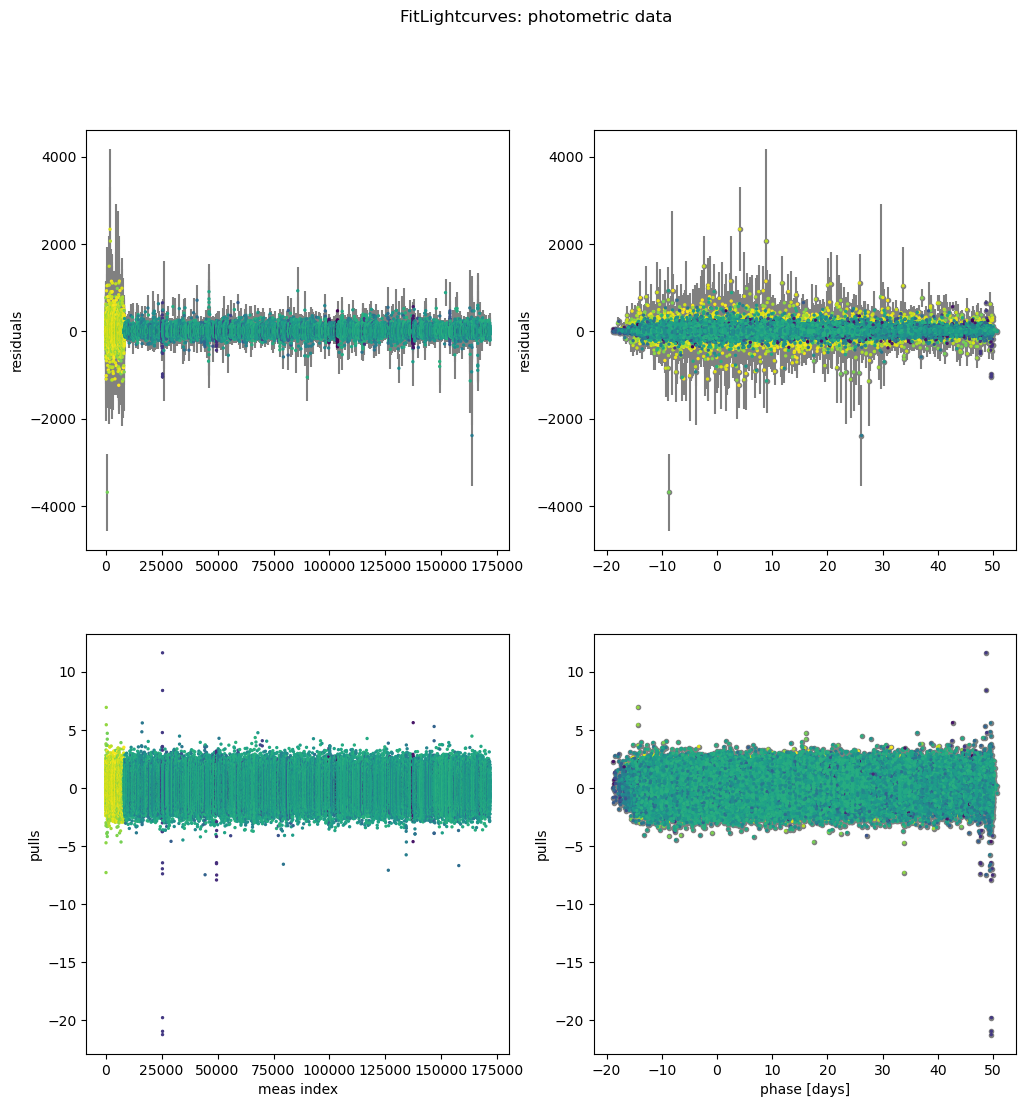

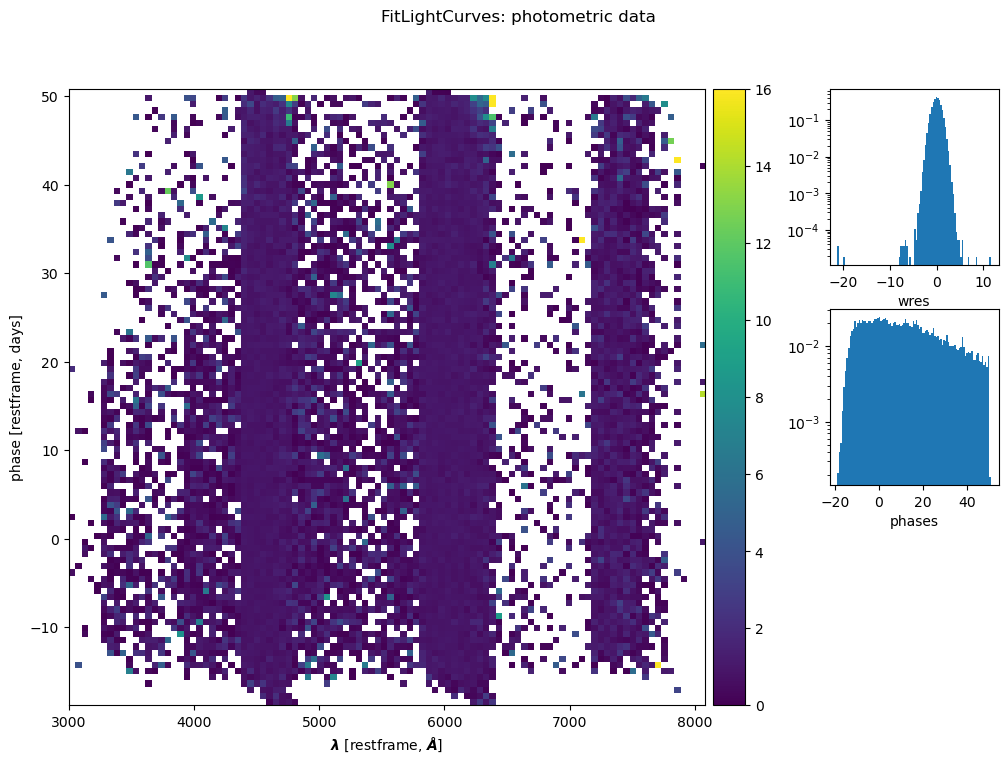

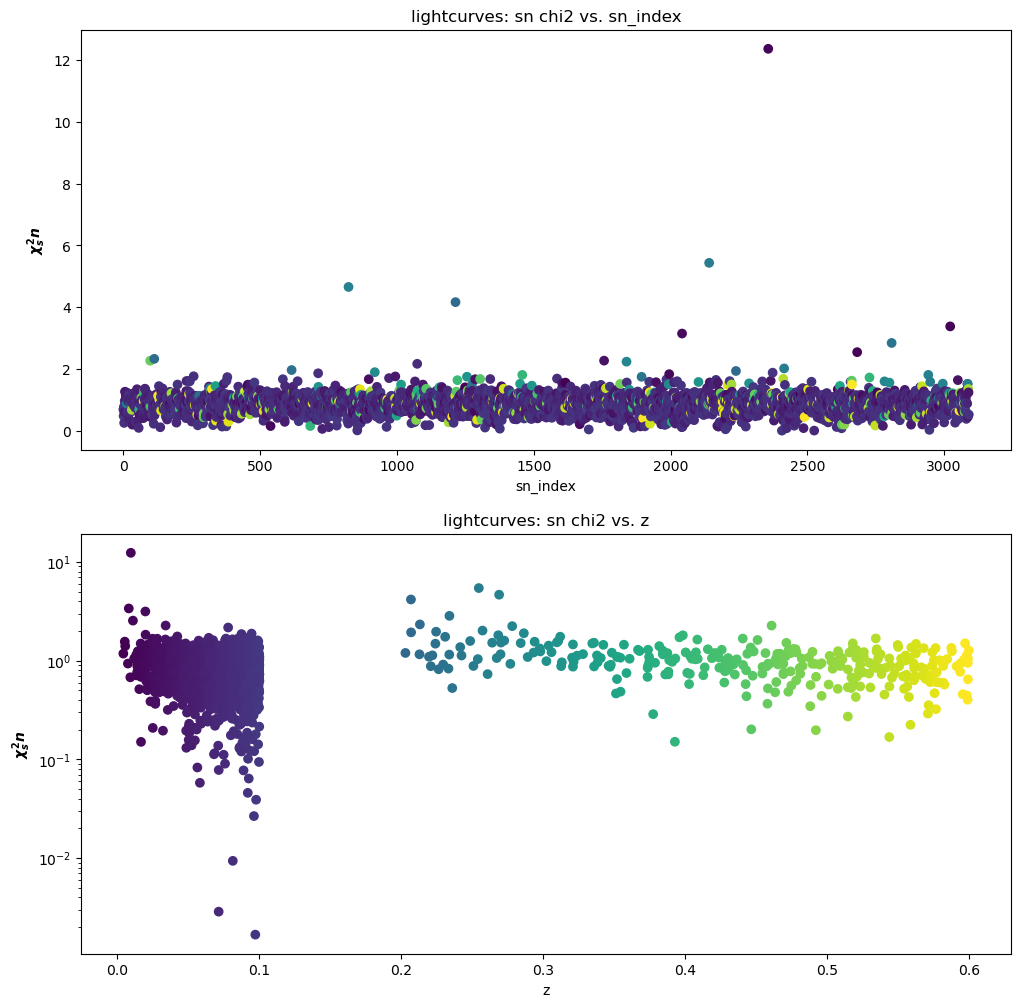

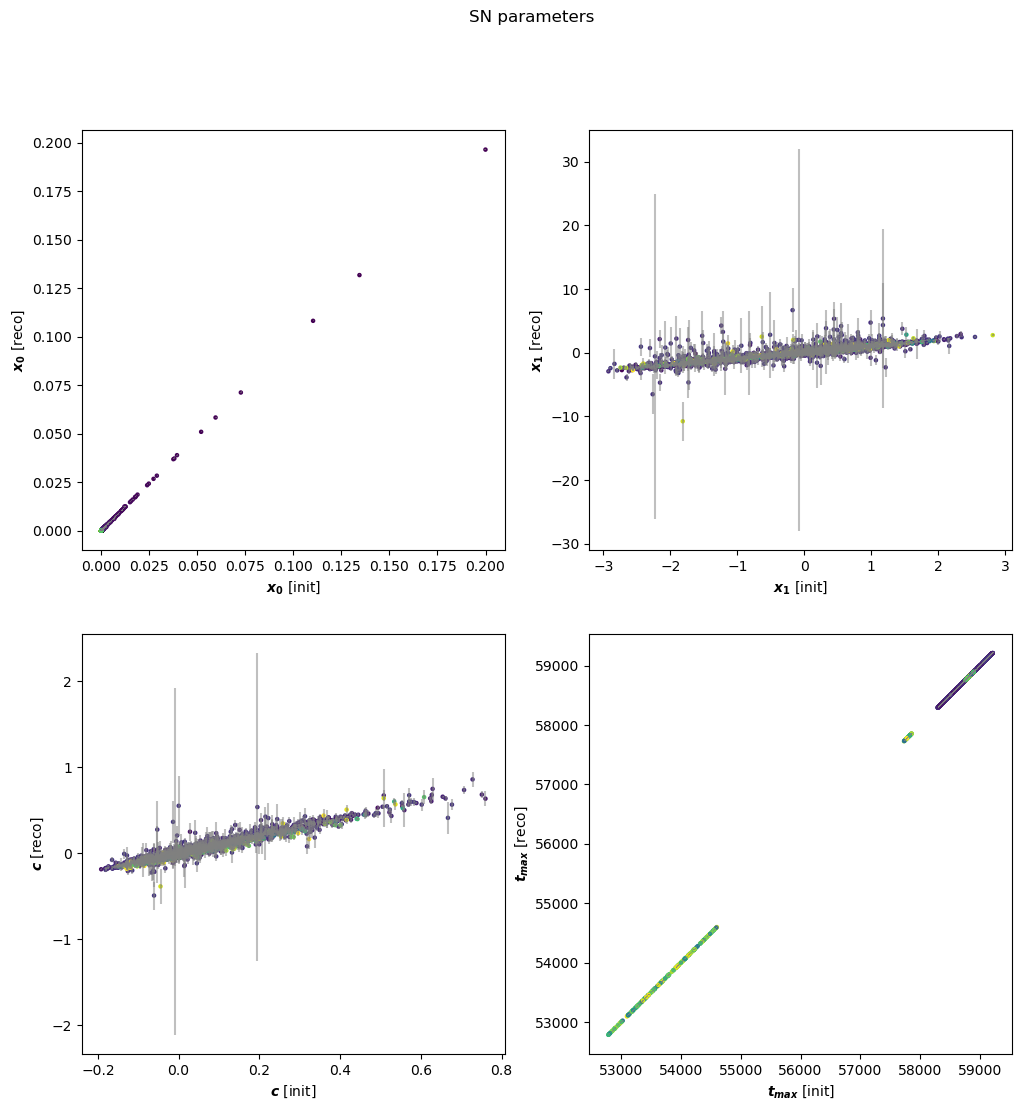

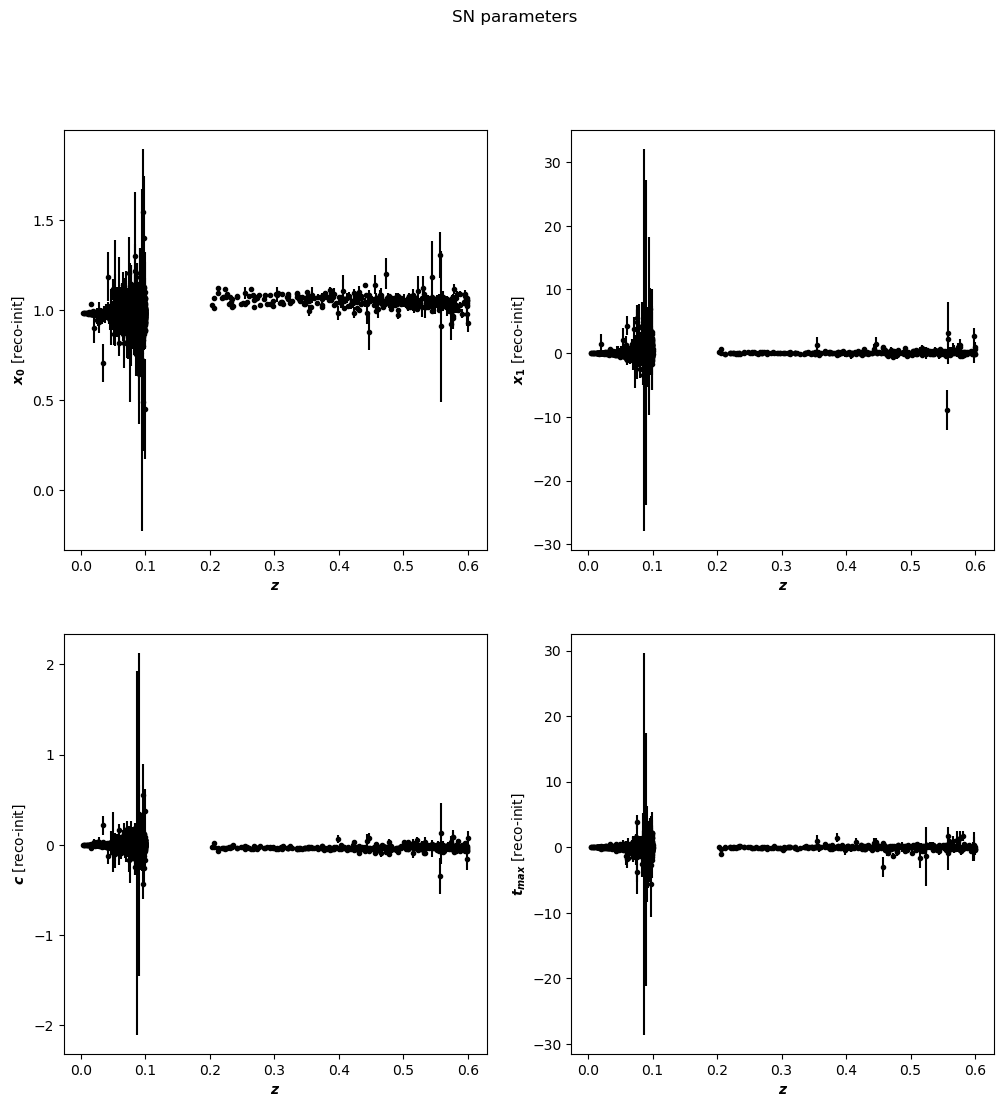

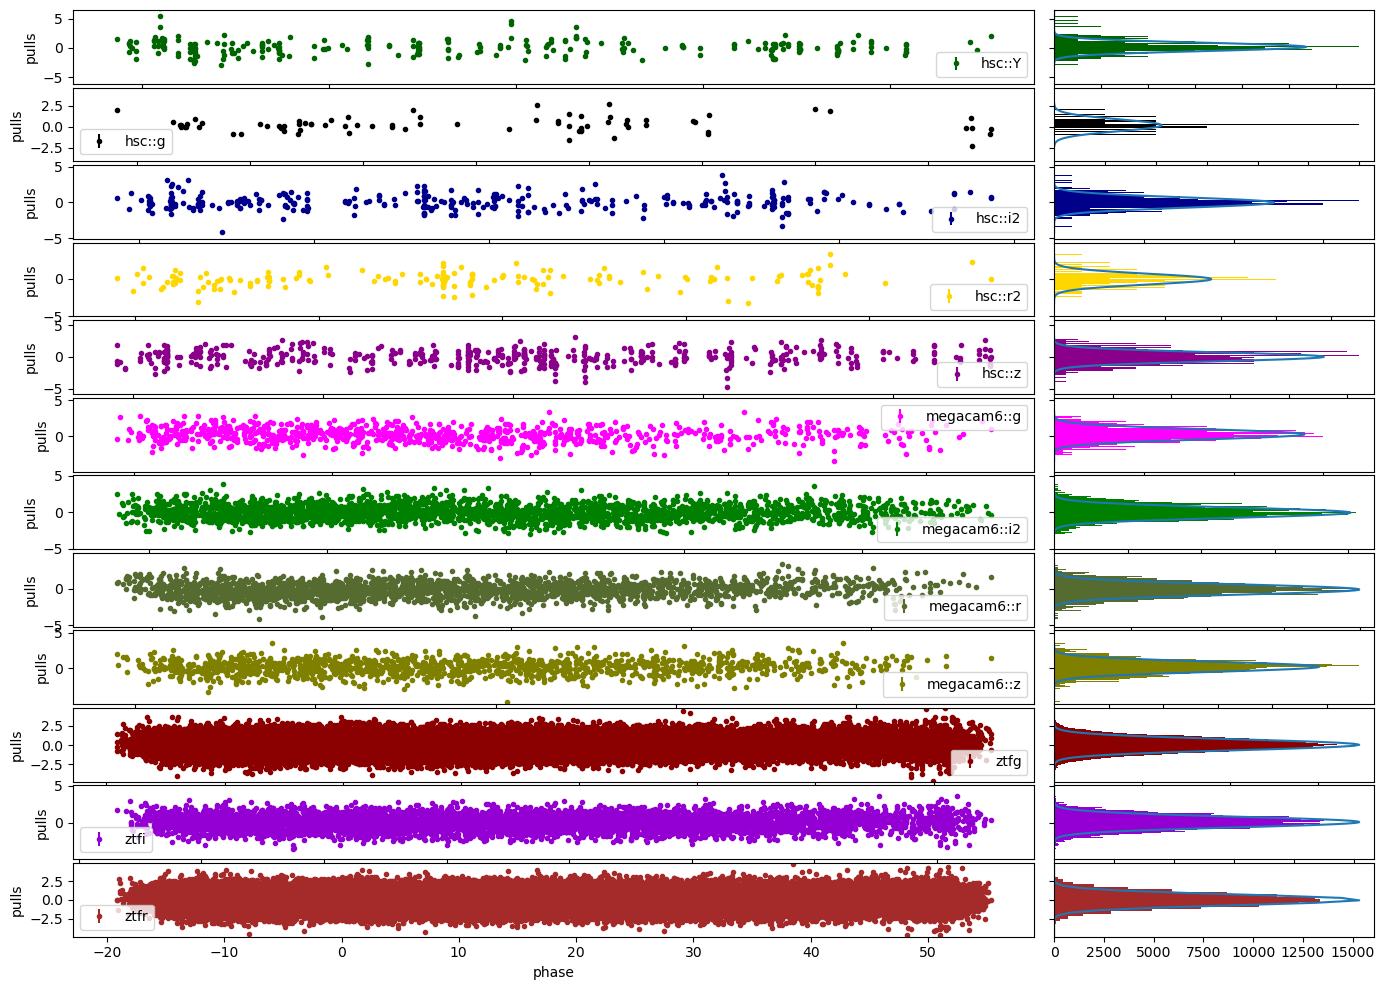

In [107]:
trainer.lc_fit()

In [ ]:
z_cosmo = mag_to_z(
    data[data.survey == "ZTF"].magobs
    + 0.14 * data[data.survey == "ZTF"].x1
    - 3.15 * data[data.survey == "ZTF"].c
)

In [8]:
fit_lc = pandas.read_pickle('/cfs/data/angi0819/Projet_LPNHE/test/1_lcfit/distillate.pkl')

In [ ]:
v_init = fit_lc.initial_model(fit_lc.initial_pars)
v_fit = fit_lc.model(fit_lc.pars)


In [ ]:
plt.figure(figsize=(20,20))
for b in np.unique(fit_lc.tds.lc_data.nt.band):
    plt.scatter(fit_lc.tds.lc_data.flux[fit_lc.tds.lc_data.band == b],
                v_fit[:len(fit_lc.tds.lc_data.nt)][fit_lc.tds.lc_data.band == b],
                s=2,
           color=color_band[b], label=b)
plt.legend()
plt.loglog(*[[1e1, 1e6]]*2, ':k')


In [ ]:
plt.figure(figsize=(20,20))
for b in np.unique(fit_lc.tds.lc_data.nt.band):
    plt.scatter(fit_lc.tds.lc_data.flux[fit_lc.tds.lc_data.band == b],
                np.abs(v_fit[:len(fit_lc.tds.lc_data.nt)][fit_lc.tds.lc_data.band == b] - v_init[:len(fit_lc.tds.lc_data.nt)][fit_lc.tds.lc_data.band == b]),
                s=2,
           color=color_band[b], label=b)
plt.legend()
plt.loglog(*[[1e1, 1e6]]*2, ':k')


In [9]:
sn_data = pandas.DataFrame(data=fit_lc.tds.sn_data.nt)
columns_rename = {'x0':'x0_init', 'x1':'x1_init', 'c':'c_init', 'tmax':'tmax_init'}
sn_data = sn_data.rename(columns = columns_rename)
sn_data = sn_data.assign(x0 = fit_lc.pars['X0'].full[fit_lc.tds.sn_data.sn_index])
sn_data = sn_data.assign(x1 = fit_lc.pars['X1'].full[fit_lc.tds.sn_data.sn_index])
sn_data = sn_data.assign(c = fit_lc.pars['c'].full[fit_lc.tds.sn_data.sn_index])
sn_data = sn_data.assign(t0 = fit_lc.pars['tmax'].full[fit_lc.tds.sn_data.sn_index])
sn_data['name'] = sn_data.sn
sn_data.to_parquet('/cfs/data/angi0819/Projet_LPNHE/test/1_lcfit/' + 'output_params' + '.parquet')


2025-03-19 14:26:21 INFO nacl.dataset - indexing light curves
2025-03-19 14:26:21 INFO nacl.dataset - indexing spectra
2025-03-19 14:26:21 WARNING nacl.dataset - _index_spectra: no spectra no index - pass
2025-03-19 14:26:21 INFO nacl.models.salt2.salt - user provided grid in wavelength
2025-03-19 14:26:21 INFO nacl.models.salt2.salt - user provided grid in phase
2025-03-19 14:26:21 INFO nacl.models.salt2.salt - initializing lightcurve eval unit
2025-03-19 14:26:21 WARNING py.warnings - /cfs/home/angi0819/conda/0.2/envs/georges/lib/python3.12/site-packages/dust_extinction/helpers.py:30: UserWarning: x has no units, assuming x units are inverse microns
  warnings.warn(

2025-03-19 14:26:21 INFO nacl.models.salt2.salt - user provided grid in wavelength
2025-03-19 14:26:21 INFO nacl.models.salt2.salt - user provided grid in phase
2025-03-19 14:26:26 INFO nacl.dataset - indexing light curves
2025-03-19 14:26:26 INFO nacl.dataset - indexing spectra
2025-03-19 14:26:26 WARNING nacl.dataset -

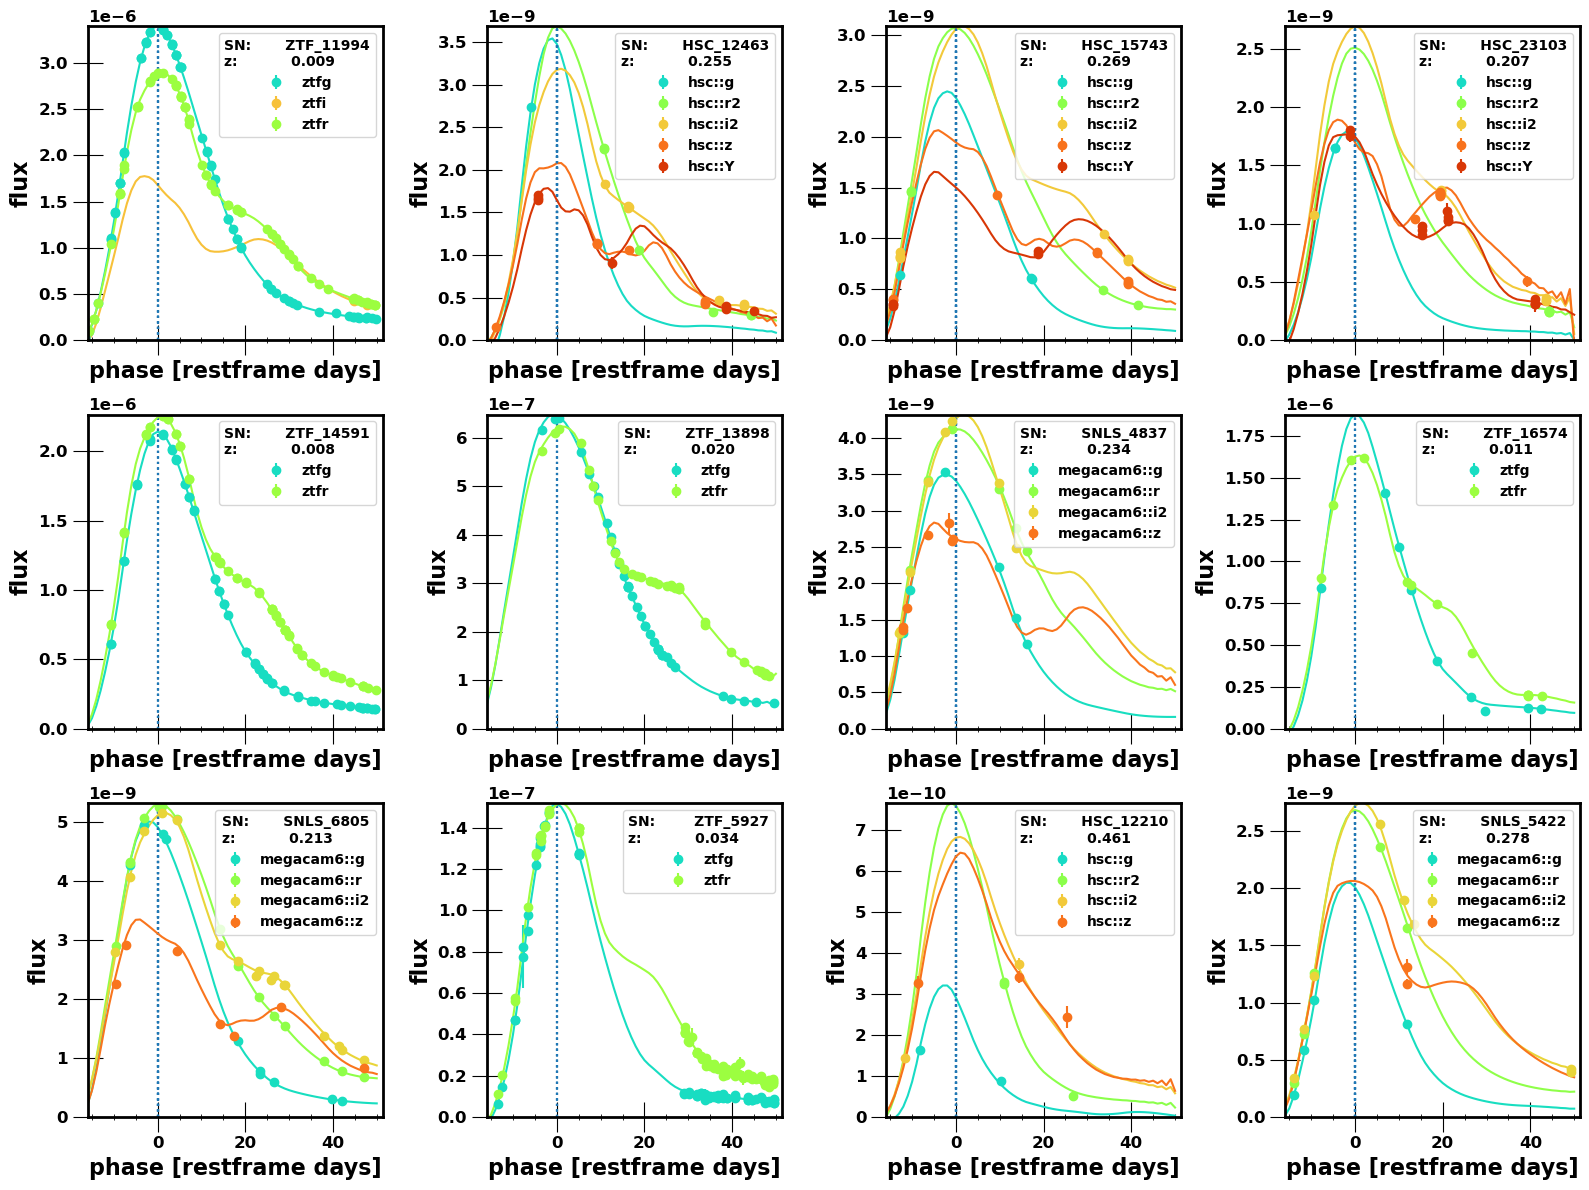

In [10]:
fit_lc.plot_lcs(nsn=12)
plt.tight_layout()

In [11]:
sn_data['magobs'] = -2.5*np.log10(sn_data.x0)
sn_data["mu"] = sn_data.magobs + 0.14*sn_data.x1 - 3.15*sn_data.c

In [13]:
cov = fit_lc.covmat
iii = np.hstack([fit_lc.tds.sn_data.sn_index + i * len(fit_lc.tds.sn_data) for i in range(4)])
cov_reduced = cov[:, iii][iii]
np.save('/cfs/data/angi0819/Projet_LPNHE/test/1_lcfit/' + 'output_cov' + '.npy', cov_reduced.toarray())

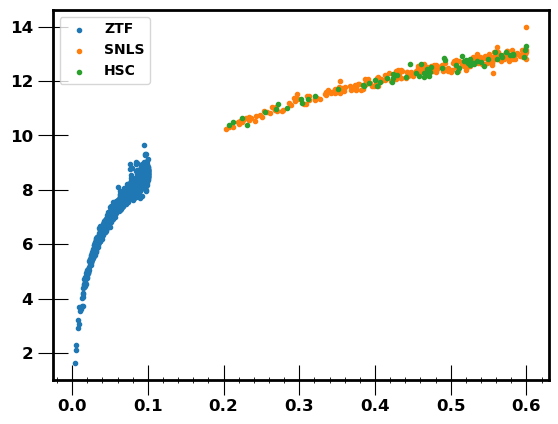

In [14]:
for s in sn_data.survey.unique():
    plt.scatter(sn_data[sn_data.survey==s].z, sn_data[sn_data.survey==s].mu, color=survey_colors[s], marker=".", label=s)
plt.legend()

### Edris

In [15]:
from edris.georgesutils import CosmoFitter

In [350]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

In [351]:
fitter = CosmoFitter(
    '/cfs/data/angi0819/Projet_LPNHE/test/1_lcfit/' + "output_params.parquet",
    '/cfs/data/angi0819/Projet_LPNHE/test/1_lcfit/' + "output_cov.npy",
    niter=1000,
    lmbda=1e4,
    tol=1e-2,
    max_iter_tncg=None,
    n_bins=21,
    verbose=True,  # TODO make edris use standard logging
    output_save_path='/cfs/data/angi0819/Projet_LPNHE/test/')


initial number of supernovae = 3091
|x_1| + \sigma_{x_1} < 5 : discarded = 31 | remaining = 3060 (99.00%)
|c| < 0.3 : discarded = 173 | remaining = 2887 (93.40%)
\sigma_{c} < 0.03 : discarded = 506 | remaining = 2381 (77.03%)


In [352]:
fitter.starting_point(flcdm=True)

In [353]:
fitter.edris_x0

{'coef': Array([-0.1,  3.1], dtype=float64),
 'variables': Array([[ 0.71385667, -0.21630375,  0.24031672, ..., -0.9733896 ,
         -1.29535726,  0.80355837],
        [-0.0625687 ,  0.22685496,  0.16144687, ...,  0.0867515 ,
          0.20834288, -0.08133899]], dtype=float64),
 'sigma_int': Array([0.12], dtype=float64),
 'M0': Array([-29.5], dtype=float64),
 'Omega_m': Array([0.3], dtype=float64)}

In [ ]:
fitter(flcdm=True, fwcdm=False)

iter 0/1000. Loss: -2.2e+03->-7.7e+03(-5.5e+03), ρ=0.53, λ=10000.0
iter 1/1000. Loss: -7.7e+03->-7.8e+03(-47), ρ=0.72, λ=10000.0
iter 2/1000. Loss: -7.8e+03->-7.8e+03(-14), ρ=0.83, λ=3000.0
iter 3/1000. Loss: -7.8e+03->-7.8e+03(-11), ρ=0.72, λ=3000.0
iter 4/1000. Loss: -7.8e+03->-7.8e+03(-2.7), ρ=0.79, λ=900.0
iter 5/1000. Loss: -7.8e+03->-7.8e+03(-2.2), ρ=0.81, λ=270.0
iter 6/1000. Loss: -7.8e+03->-7.8e+03(-2.9), ρ=0.87, λ=81.0
iter 7/1000. Loss: -7.8e+03->-7.8e+03(-4.1), ρ=0.83, λ=24.3
iter 8/1000. Loss: -7.8e+03->-7.8e+03(-3.8), ρ=0.77, λ=7.29
iter 9/1000. Loss: -7.8e+03->-7.8e+03(-2.1), ρ=0.72, λ=7.29
iter 10/1000. Loss: -7.8e+03->-7.8e+03(-0.52), ρ=0.78, λ=2.187
iter 11/1000. Loss: -7.8e+03->-7.8e+03(-0.27), ρ=0.68, λ=2.187


In [7]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

In [244]:
df= pandas.read_csv('/cfs/data/angi0819/Projet_LPNHE/test/edris_binnedquality_cuts_edris.dat', delimiter=r'\s+', skiprows=2).rename(columns={'#end':'cut'})

2025-03-21 14:58:33 WARNING py.warnings - /cfs/home/angi0819/conda/0.2/envs/georges/lib/python3.12/site-packages/lemaitre/georges/distance_comparison.py:138: RuntimeWarning: Mean of empty slice.
  mu_binned_means = np.array([mu_fit[z_binned_indices == i].mean() for i in range(1, len(bins))])

2025-03-21 14:58:33 WARNING py.warnings - /cfs/home/angi0819/conda/0.2/envs/georges/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)

2025-03-21 14:58:33 WARNING py.warnings - /cfs/home/angi0819/conda/0.2/envs/georges/lib/python3.12/site-packages/lemaitre/georges/distance_comparison.py:139: RuntimeWarning: Mean of empty slice.
  mu_real_binned_means = np.array([mu_true[z_binned_indices == i].mean() for i in range(1, len(bins))])

2025-03-21 14:58:33 WARNING py.warnings - /cfs/home/angi0819/conda/0.2/envs/georges/lib/python3.12/site-packages/lemaitre/georges/distance_comparison.py:141: RuntimeWar

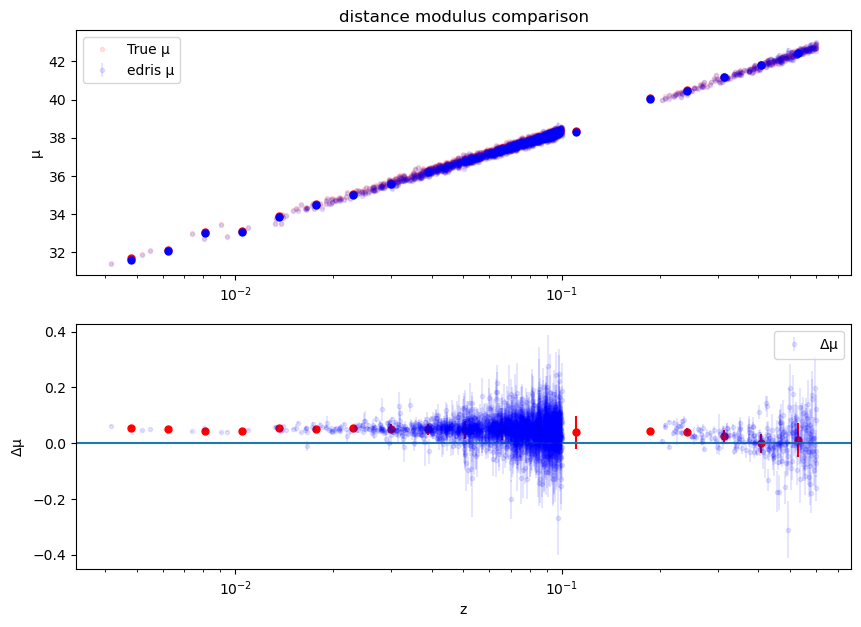

In [250]:
from lemaitre.georges.distance_comparison import compare_mu
compare_mu('/cfs/data/angi0819/Projet_LPNHE/test/1_lcfit/output_params.parquet', '/cfs/data/angi0819/Projet_LPNHE/test/1_lcfit/output_cov.npy',
           '/cfs/data/angi0819/Projet_LPNHE/test/flcdm_edris_output.pkl', true_alpha=0.14, true_beta=3.15,
           edris_cuts_index=(df.cut == 'is_ok').values,savefig_path='/cfs/data/angi0819/Projet_LPNHE/test/')


In [372]:
with open('/cfs/data/angi0819/Projet_LPNHE/test/edris_binned_edris_output.pkl', 'rb') as fin:
    edris_res = pickle.loads(fin.read())


In [373]:
edris_res.keys()

dict_keys(['res', 'res_cov', 'loss', 'lambda', 'iter_params'])

In [251]:
nacl_fit = pandas.read_parquet('/cfs/data/angi0819/Projet_LPNHE/test/1_lcfit/output_params.parquet')

In [23]:
data, lc = load_from_skysurvey("/cfs/data/angi0819/Projet_LPNHE/dataset_2M++.pkl", survey="ZTF")

In [78]:
source = sncosmo.get_source('salt2', version='2.4')

In [123]:
model = sncosmo.Model(source)

In [132]:
snia = skysurvey.SNeIa()

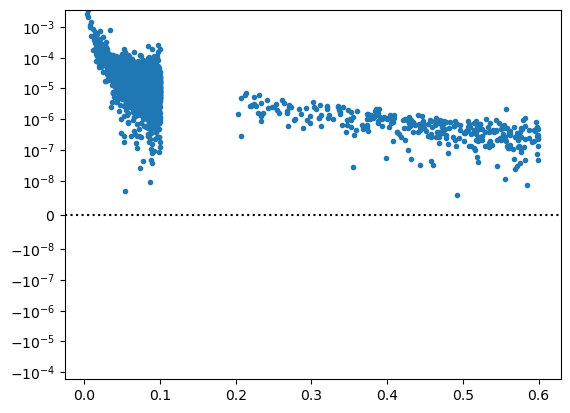

In [281]:
plt.scatter(nacl_fit.z,
            np.abs(nacl_fit.x0_init - nacl_fit.x0),
            marker='.')
plt.axhline(0, linestyle=':', color='k')
plt.yscale('symlog', linthresh=1e-8)

Text(0, 0.5, '$\\Delta x_0 = |x_0^{true} - x_0^{fit}|$')

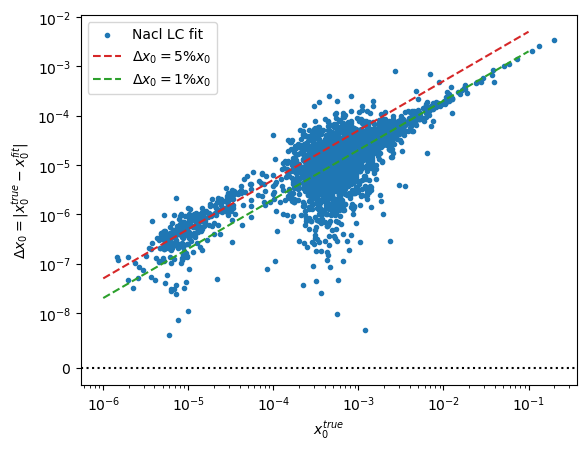

In [305]:
plt.scatter(nacl_fit.x0_init,
            np.abs(nacl_fit.x0_init - nacl_fit.x0),
            marker='.',
            label='Nacl LC fit')
plt.axhline(0, linestyle=':', color='k')
plt.plot([1e-6, 1e-1], 0.05*np.array([1e-6, 1e-1]), linestyle='--', color='tab:red', label=r"$\Delta x_0 = 5\% x_0$")
plt.plot([1e-6, 1e-1], 0.02*np.array([1e-6, 1e-1]), linestyle='--', color='tab:green', label=r"$\Delta x_0 = 1\% x_0$")
plt.yscale('symlog', linthresh=1e-8)
plt.xscale('log')
plt.xlabel(r'$x_0^{true}$')
plt.legend()
plt.ylabel(r'$\Delta x_0 = |x_0^{true} - x_0^{fit}|$')

In [398]:
source.peakmag(band="bessellb", magsys="ab")

10.502069945029266

In [374]:
n = {k1:edris_res['res_cov'][k1][k1].shape[1] for k1 in edris_res['res_cov'].keys()}
cov = jnp.vstack([np.hstack([edris_res['res_cov'][k1][k2].reshape(n[k1], n[k2]) for k2 in edris_res['res_cov'].keys()]) for k1 in edris_res['res_cov'].keys()])

In [381]:
fitter.starting_point()
fitter.edris_x0

{'coef': Array([-0.1,  3.1], dtype=float64),
 'variables': Array([[ 0.71385667, -0.21630375,  0.24031672, ..., -0.9733896 ,
         -1.29535726,  0.80355837],
        [-0.0625687 ,  0.22685496,  0.16144687, ...,  0.0867515 ,
          0.20834288, -0.08133899]], dtype=float64),
 'sigma_int': Array([0.12], dtype=float64),
 'mu_bins': Array([ 1.6601308 ,  2.0630437 ,  3.19668899,  3.15844217,  3.56996698,
         3.79457152,  4.58937439,  4.99121007,  5.50939373,  6.03708616,
         6.53204166,  7.04608434,  7.5538591 ,  8.05918561,  8.58592964,
        10.22283819, 10.48446938, 10.55205658, 10.82722877, 11.03391495,
        11.33027958, 11.35464146, 11.65215021, 11.78803184, 11.98895249,
        12.27208849, 12.41788467, 12.59319998, 12.84087442, 13.02286255],      dtype=float64)}

In [375]:
x0 = dict(M0=-(19.3 + source.peakmag(band="bessellb", magsys="ab")),
          Omega_m=cosmo.Om0,
          coef=jnp.array([-0.14, 3.15]),
          sigma_int=jnp.array([0.1]))

In [376]:
edris_res['res']['sigma_int'] = jnp.abs(edris_res['res']['sigma_int'])

In [378]:
edris_res['iter_params'][0]

{'coef': Array([-0.13700887,  3.19063315], dtype=float64),
 'mu_bins': Array([ 1.64521885,  2.09362368,  3.19777208,  3.11639654,  3.49884278,
         3.79722557,  4.57671757,  4.98271709,  5.48571712,  6.03231255,
         6.5227582 ,  7.03228112,  7.54782587,  8.05334409,  8.58718708,
        10.20861128, 10.46408766, 10.56913702, 10.80976098, 11.0240905 ,
        11.31171361, 11.34664101, 11.64292181, 11.78024883, 12.01101816,
        12.25555771, 12.40822075, 12.59988891, 12.84358271, 13.034024  ],      dtype=float64),
 'variables': Array([[ 0.72096348, -0.22098323,  0.27112247, ..., -0.97459551,
         -1.29387849,  0.80384292],
        [-0.05944931,  0.22783018,  0.15468023, ...,  0.09076772,
          0.20860635, -0.08128212]], dtype=float64),
 'sigma_int': Array([0.15], dtype=float64)}

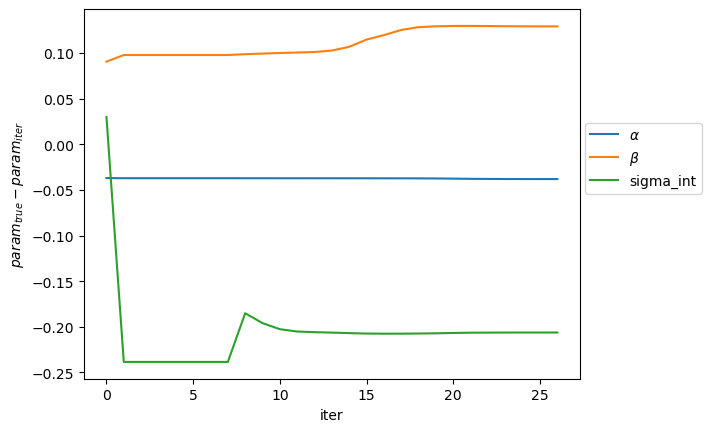

In [384]:
%matplotlib inline
for key in ["coef", 'sigma_int']:
    plt.plot([iter_p[key]-fitter.edris_x0[key] for iter_p in edris_res['iter_params']], label=[r'$\alpha$', r'$\beta$'] if key=='coef' else key)

plt.ylabel(r"$param_{true} - param_{iter}$")
plt.xlabel("iter")
plt.legend(loc=(1.01, 0.5))


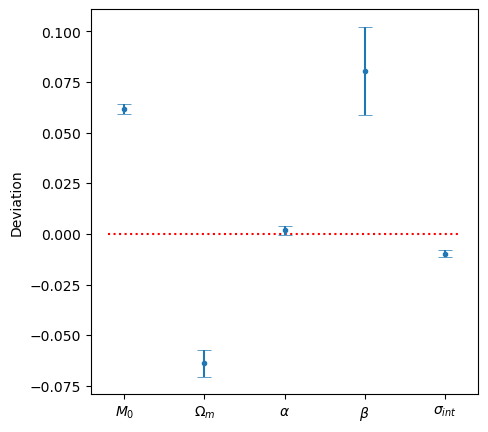

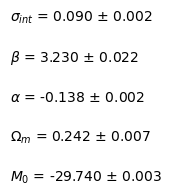

In [367]:
plot_edris_biais(edris_res['res'], x0, cov)

In [18]:
edris_res['res']['variables'].shape

(2, 2604)

# EDRIS

Attention, Uchuu avec Planck15, Abacus avec Planck18

In [ ]:
from astropy.cosmology import Planck15, Planck18

# cosmo = Planck15

In [1]:
from edris.cosmo import dL, Tcmb_to_Omega_gamma, Tcmb, mu

In [2]:
def flcdm(params, explanatory):
    p = {
        "Omega_m": params["Omega_m"],
        "Omega_gamma": cosmo.Ogamma0,
        "w": -1.0,
        "H0": params["H0"],
        "Omega_k": cosmo.Ok0,
    }
    return mu(p, explanatory["z"]) - 19.3

In [11]:
params = dict(
    H0=jnp.array([cosmo.H0.value]),
    Omega_m=jnp.array([cosmo.Om0]),
    Omega_gamma=jnp.array([cosmo.Ogamma0]),
    Omega_k=jnp.array([cosmo.Ok0]),
    w=jnp.array([-1.0]),
    coef=jnp.array([-0.14, 3.15]),
    sigma_int=jnp.array([jnp.array([0.1])]),
)

In [12]:
source = sncosmo.get_source("salt2", version="2.4")
model = sncosmo.Model(
    source=source,
    effects=[sncosmo.CCM89Dust()],
    effect_names=["mw"],
    effect_frames=["obs"],
)

In [13]:
with open("outdir/ztf_2M++_snls_hsc.pkl", "rb") as file:
    values = pickle.load(file)
    covs = pickle.load(file)

In [14]:
values = values[values.valid].copy()
data_ztf,_ = load_from_skysurvey('./data/dataset_2M++.pkl', survey='ZTF')
data_hsc,_ = load_from_skysurvey('./data/dataset_hsc.pkl', survey='HSC')
data_snls,_ = load_from_skysurvey('./data/dataset_snls.pkl', survey='SNLS')
data=pandas.concat([data_ztf, data_hsc, data_snls])
values = values.join(data[['ra','dec']])
values.ra = (values.ra/180-1)*np.pi
values.dec = values.dec/180*np.pi
values["rcom"] = cosmo.comoving_distance(values.z).value

In [15]:
from scipy.linalg import block_diag

full_matrix = block_diag(*[covs[i] for i in values.index])
n = len(values)
full_cov_sorted = full_matrix[
    :,
    [
        *[3 * i for i in range(n)],
        *[3 * i + 1 for i in range(n)],
        *[3 * i + 2 for i in range(n)],
    ],
][
    [
        *[3 * i for i in range(n)],
        *[3 * i + 1 for i in range(n)],
        *[3 * i + 2 for i in range(n)],
    ],
    :,
]

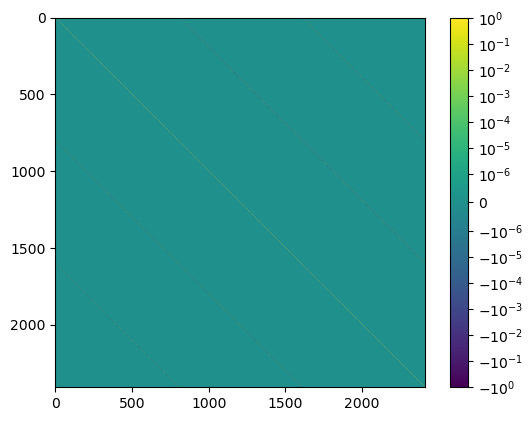

In [16]:
from matplotlib.colors import SymLogNorm

plt.imshow(
    jnp.diag(1 / jnp.sqrt(jnp.diag(full_cov_sorted)))
    @ full_cov_sorted
    @ jnp.diag(1 / jnp.sqrt(jnp.diag(full_cov_sorted))),
    norm=SymLogNorm(vmin=-1, vmax=1, linthresh=1e-6),
)
plt.colorbar()

In [18]:
values["survey"] = values.index.map(lambda s: s.split("_")[0])

/home/okc/anaconda3/envs/lemaitre/lib/python3.12/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/home/okc/anaconda3/envs/lemaitre/lib/python3.12/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
2025-02-24 11:51:16,708 INFO Covariance matrix generated from flip with carreres23 model in 9.69e-01 seconds
[ 000000.91 ]: 02-24 11:51  root            INFO     Covariance matrix generated from flip with carreres23 model in 9.69e-01 seconds


Text(0.5, 1.0, '$Cov_{mm}$')

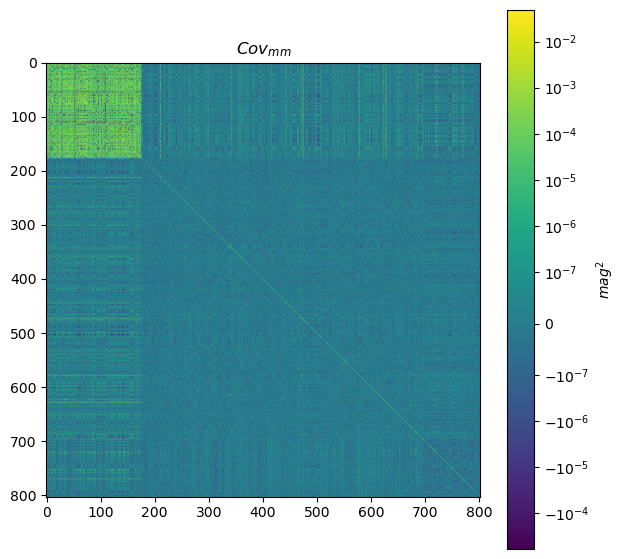

In [20]:
k, p = np.loadtxt('./data/power_spectrum.txt')

from flip import covariance, utils
coordinates = np.array([values['ra'],
                        values['dec'],
                        values['rcom']])
sigmau_fiducial = 15

power_spectrum_dict = {"vv": [[k, p * utils.Du(k, sigmau_fiducial) ** 2]]}

size_batch=10_000
number_worker=64

covariance_fit = covariance.CovMatrix.init_from_flip(
    "carreres23",
    "velocity",
    power_spectrum_dict,
    coordinates_velocity=coordinates,
    size_batch=size_batch,
    number_worker=number_worker,
)

covariance_fit.compute_full_matrix()
vpec_cov = (5/(c.value*1e-3*np.log(10)))**2*covariance_fit.covariance_dict['vv'][0] * \
            (np.array([1/values.z.values]).T @ \
             np.array([1/values.z.values]))
from matplotlib.colors import SymLogNorm
plt.figure(figsize=(7,7))
plt.imshow(vpec_cov, norm=SymLogNorm(linthresh=1e-7))
plt.colorbar(label=r'$mag^2$')
plt.title(r"$Cov_{mm}$")

In [25]:
filt = (
    (values.c < 0.3) # & (values.err_x1 + np.abs(values.x1) < 5) & (values.err_c < 0.05)
)  # &\
# ((values.survey != 'ZTF') | (values.z < 0.1))
sum(filt)

780

In [26]:
surveys = set(values[filt]["survey"])
survey_map = dict(zip(surveys, range(len(surveys))))
survey_id = jnp.array([survey_map[s] for s in values[filt]["survey"]])

In [27]:
obs = Obs(
    mag=jnp.array(values[filt].magobs),
    variables=jnp.hstack([jnp.array(values[filt].x1), jnp.array(values[filt].c)]),
)

In [28]:
exp = dict(
    z=jnp.array(values[filt].z),
    survey_id=survey_id,
    survey_map=survey_map,
)

In [29]:
n = len(values)

In [42]:
cov = FullCovariance(
    full_cov_sorted[:n, :n] + vpec_cov, full_cov_sorted[n:, n:], full_cov_sorted[:n, n:]
)

In [43]:
cov = cov.select(filt.values)

In [32]:
exp["map_survey"] = {
    v: k for v, k in zip(exp["survey_map"].values(), exp["survey_map"].keys())
}

In [33]:
x0 = dict(
    H0=jnp.array([cosmo.H0.value]),
    Omega_m=jnp.array([cosmo.Om0]),
    coef=jnp.array([-0.14, 3.15]),
    variables=jnp.array(obs.variables.reshape((2, -1))),
    sigma_int=jnp.array([0.1]),
)

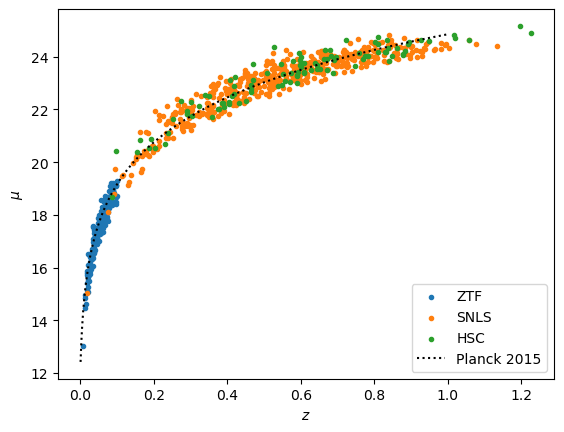

In [34]:
for survey in exp["survey_map"].keys():
    plt.scatter(
        exp["z"][exp["survey_id"] == exp["survey_map"][survey]],
        obs.mag[
            exp["survey_id"] == exp["survey_map"][survey]
        ],  # - jnp.matmul(x0["coef"], obs.variables.reshape(2,-1)),
        c=survey_colors[survey],
        marker=".",
        label=survey,
    )

plt.plot(
    np.linspace(1e-3, 1, 1000),
    flcdm(params, {"z": jnp.linspace(5e-3, 1, 1000)}),
    linestyle=":",
    color="k",
    label="Planck 2015",
)
plt.xlabel(r"$z$")
plt.ylabel(r"$\mu$")
plt.legend()

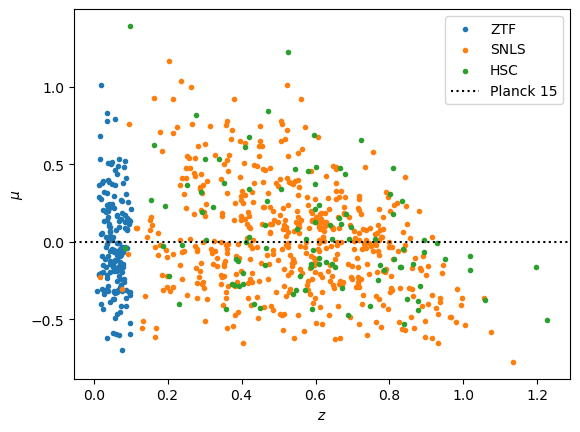

In [35]:
for survey in exp["survey_map"].keys():
    plt.scatter(
        exp["z"][exp["survey_id"] == exp["survey_map"][survey]],
        obs.mag[exp["survey_id"] == exp["survey_map"][survey]]
        - flcdm(params, {"z": exp["z"][exp["survey_id"] == exp["survey_map"][survey]]}),
        # - jnp.matmul(x0["coef"], obs.variables.reshape(2,-1)),
        c=survey_colors[survey],
        marker=".",
        label=survey,
    )

plt.axhline(0, linestyle=":", color="k", label="Planck 15")
plt.xlabel(r"$z$")
plt.ylabel(r"$\mu$")
plt.legend()

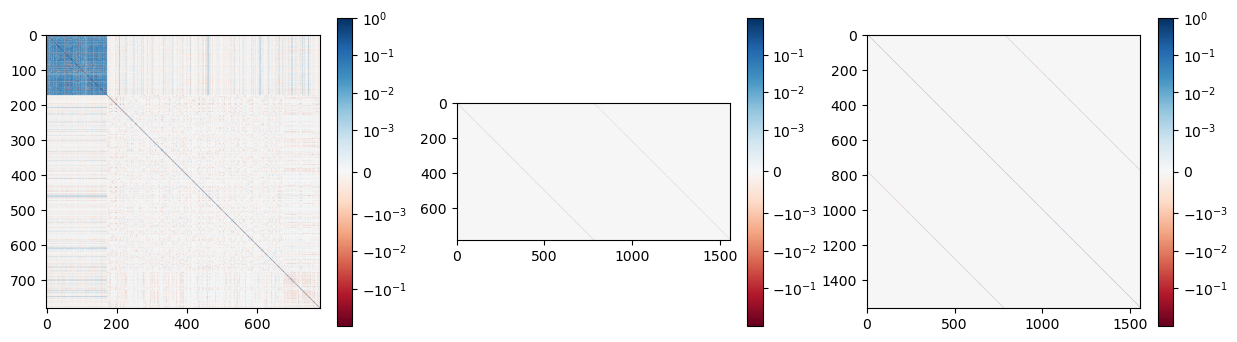

In [60]:
fig, (ax_mm, ax_mx, ax_xx) = plt.subplots(ncols = 3, figsize=(15,4))
im_mm = ax_mm.imshow(jnp.diag(1 / jnp.sqrt(jnp.diag(cov.C_mm))) @ cov.C_mm @ jnp.diag(1 / jnp.sqrt(jnp.diag(cov.C_mm))), norm=SymLogNorm(linthresh=1e-3), cmap="RdBu")
plt.colorbar(im_mm, ax=ax_mm)
im_mx = ax_mx.imshow(jnp.diag(1 / jnp.sqrt(jnp.diag(cov.C_mm))) @ cov.C_mx @ jnp.diag(1 / jnp.sqrt(jnp.diag(cov.C_xx))), norm=SymLogNorm(linthresh=1e-3), cmap="RdBu")
plt.colorbar(im_mx, ax=ax_mx)
im_xx = ax_xx.imshow(jnp.diag(1 / jnp.sqrt(jnp.diag(cov.C_xx))) @ cov.C_xx @ jnp.diag(1 / jnp.sqrt(jnp.diag(cov.C_xx))), norm=SymLogNorm(linthresh=1e-3), cmap="RdBu")
plt.colorbar(im_xx, ax=ax_xx)


In [61]:
L = lambda x: likelihood(
    x, exp, cov, obs, cosmo=flcdm, truncated=False, restricted=False
)

In [62]:
L(x0)

Array(-1831.46757502, dtype=float64)

In [63]:
fit_params = dict(niter=1000, lmbda=1e4, tol=1e-3, max_iter_tncg=None, verbose=True)

In [ ]:
res, loss, lmbda, iter_params = tncg(L, x0, **fit_params)

iter 0/1000. Loss: -1.8e+03->-2.1e+03(-2.7e+02), ρ=0.66, λ=10000.0
iter 1/1000. Loss: -2.1e+03->-2.2e+03(-75), ρ=0.79, λ=3000.0
iter 2/1000. Loss: -2.2e+03->-2.3e+03(-1e+02), ρ=0.87, λ=900.0
iter 3/1000. Loss: -2.3e+03->-2.4e+03(-90), ρ=0.70, λ=900.0
iter 4/1000. Loss: -2.4e+03->-2.4e+03(-17), ρ=0.78, λ=270.0
iter 5/1000. Loss: -2.4e+03->-2.4e+03(-15), ρ=0.82, λ=81.0
iter 6/1000. Loss: -2.4e+03->-2.4e+03(-19), ρ=0.86, λ=24.3
iter 7/1000. Loss: -2.4e+03->-2.4e+03(-26), ρ=0.82, λ=7.29
iter 8/1000. Loss: -2.4e+03->-2.5e+03(-21), ρ=0.72, λ=7.29
iter 9/1000. Loss: -2.5e+03->-2.5e+03(-4.1), ρ=0.74, λ=7.29
iter 10/1000. Loss: -2.5e+03->-2.5e+03(-0.97), ρ=0.75, λ=2.187
iter 11/1000. Loss: -2.5e+03->-2.5e+03(-0.33), ρ=0.63, λ=2.187
iter 12/1000. Loss: -2.5e+03->-2.5e+03(-0.025), ρ=0.68, λ=2.187
iter 13/1000. Loss: -2.5e+03->-2.5e+03(-0.0056), ρ=0.85, λ=0.6560999999999999
iter 14/1000. Loss: -2.5e+03->-2.5e+03(-0.0098), ρ=0.90, λ=0.19682999999999998
iter 15/1000. Loss: -2.5e+03->-2.5e+03(-0.013)

In [ ]:
jax.tree.map(lambda x, y: x - y, res, x0)

{'H0': Array([0.10968479], dtype=float64),
 'Omega_m': Array([0.03842201], dtype=float64),
 'coef': Array([0.00107124, 0.08564002], dtype=float64),
 'sigma_int': Array([-0.05633393], dtype=float64),
 'variables': Array([[-3.44540599e-05,  3.91443669e-03,  1.40488349e-04,
          4.36421776e-03, -5.00069360e-05,  9.17098905e-02,
         -1.26318139e-03,  3.26441414e-05,  1.95653067e-05,
          4.51968282e-04,  6.32902602e-06, -2.42484952e-02,
          3.02684953e-06, -1.69717871e-03,  4.98088621e-05,
          3.89920433e-02,  1.92416775e-05, -9.67308297e-03,
          5.11955137e-04,  1.37461843e-02,  2.84015021e-05,
         -2.71166262e-02, -2.25066283e-03, -8.21139214e-03,
          3.69384593e-05, -2.13703202e-02,  1.02005677e-04,
          2.19013888e-02, -1.84774901e-06,  9.29679613e-04,
          6.24470110e-07, -5.33391679e-02,  1.51235227e-05,
         -3.56492440e-03,  4.65290772e-04, -2.13581083e-02,
         -1.63198571e-05,  3.25037352e-03,  7.68268878e-04,
        

In [168]:
hess = jax.hessian(L)(res)

In [ ]:
n = {k1: hess[k1][k1].shape[1] for k1 in hess.keys()}
n["variables"] *= n["coef"]
flatten_hess = jnp.vstack(
    [
        np.hstack([hess[k1][k2].reshape(n[k1], n[k2]) for k2 in hess.keys()])
        for k1 in hess.keys()
    ]
)
cov_res = jnp.linalg.inv(0.5 * flatten_hess)

In [ ]:
with open("outdir/edris_2M++_snls_hsc.pkl", "wb") as file:
    pickle.dump(obs, file)
    pickle.dump(exp, file)
    pickle.dump(cov, file)
    pickle.dump(res, file)
    pickle.dump(cov_res, file)

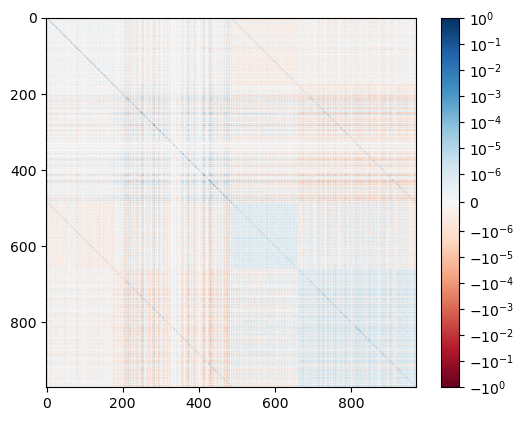

In [ ]:
from matplotlib.colors import SymLogNorm

plt.imshow(cov_res, norm=SymLogNorm(linthresh=1e-6, vmin=-1, vmax=1), cmap="RdBu")
plt.colorbar()

In [ ]:
potential_keys = ["H0", "M0", "Omega_m", "Omega_r", "Omega_l", "coef", "sigma_int"]
latex_keys = {
    "H0": "$H_0$",
    "M0": "$M_0$",
    "Omega_m": "$\\Omega_m$",
    "Omega_r": "$\\Omega_r$",
    "Omega_l": "$\\Omega_l$",
    "coef": ["$\\alpha$", "$\\beta$"],
    "sigma_int": "$\\sigma_{int}$",
    "alpha": "$\\alpha$",
    "beta": "$\\beta$",
}

In [ ]:
plt.rc("axes", labelsize=20)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=14)  # fontsize of the tick labels
plt.rc("ytick", labelsize=14)  # fontsize of the tick labels
plt.rc("legend", fontsize=12)  # legend fontsize

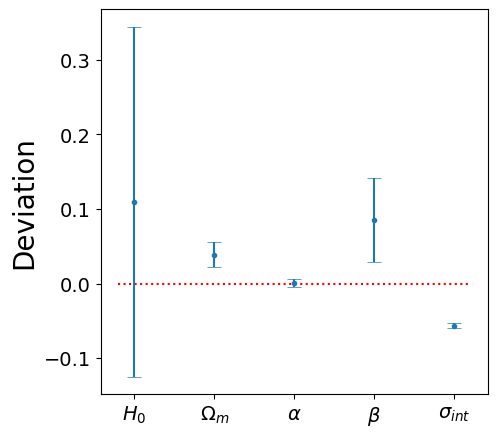

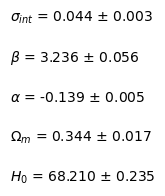

In [ ]:
fig, ax = plt.subplots(figsize=(5, 5))
keys = np.array(list(res.keys()))[[p in potential_keys for p in res.keys()]]
_labels, _values, _diffs = [], [], []
for k in keys:
    _labels += latex_keys[k] if isinstance(latex_keys[k], list) else [latex_keys[k]]
    _values += list(res[k])
    _diffs += list(res[k] - x0[k])
n_pars = len(keys)
ax.hlines(0, -1, 5 * n_pars + 1, color="r", linestyle=":")
ax.set_xticks(5 * np.arange(n_pars + 1), _labels)
ax.set_ylabel("Deviation")
plt.errorbar(
    5 * np.arange(n_pars + 1),
    _diffs,
    yerr=jnp.sqrt(jnp.diag(cov_res)[: n_pars + 1]),
    linestyle="",
    marker=".",
    capsize=5,
    capthick=0.5,
)
# plt.savefig('../figures/Uchuu_final_params.png')
fig, ax = plt.subplots(figsize=(1, 1))
ax.axis("off")
for i, pos in enumerate(np.arange(n_pars + 1) * 0.4):
    fig.text(
        0,
        pos,
        _labels[i] + f" = {_values[i]:.3f} $\\pm$ {jnp.sqrt(jnp.diag(cov_res)[i]):.3f}",
    )

In [ ]:
def plot_hubble(obs, res, cov_res, cosmo, x0):
    std_mag = obs.mag - jnp.matmul(res["coef"], res["variables"])

    fig, (ax1, ax2) = plt.subplots(
        nrows=2, sharex="col", figsize=(7, 6), gridspec_kw={"height_ratios": [3, 1]}
    )
    ax1.set_xscale("log")
    ax1.scatter(
        exp["z"], std_mag, s=0.5, alpha=0.3, color="k", label="Standardised magnitudes"
    )
    ax1.plot(
        np.linspace(5e-3, 1.2, 1000),
        cosmo(x0, {"z": np.linspace(5e-3, 1.2, 1000)}),
        color="tab:green",
        linestyle=":",
        label="Underlying cosmo",
    )

    ax2.scatter(exp["z"], std_mag - cosmo(x0, exp), color="k", s=0.5, alpha=0.3)

    if "mu_bins" in res.keys():
        ax1.errorbar(
            exp["z_bins"],
            res["mu_bins"],
            yerr=jnp.sqrt(jnp.diag(cov_res[2 : 2 + n_bins, 2 : 2 + n_bins])),
            color="tab:blue",
            label="edris",
        )
        ax2.errorbar(
            exp["z_bins"],
            res["mu_bins"] - cosmo(x0, {"z": exp["z_bins"]}),
            yerr=jnp.sqrt(jnp.diag(cov_res[2 : 2 + n_bins, 2 : 2 + n_bins])),
            color="tab:blue",
        )
    else:
        ax1.plot(
            jnp.linspace(5e-3, 1.2, 1000),
            cosmo(res, {"z": jnp.linspace(5e-3, 1.2, 1000)}),
            color="tab:blue",
            label="edris",
        )
        ax2.plot(
            jnp.linspace(5e-3, 1.2, 1000),
            cosmo(res, {"z": jnp.linspace(5e-3, 1.2, 1000)})
            - cosmo(x0, {"z": jnp.linspace(5e-3, 1.2, 1000)}),
            color="tab:blue",
        )

    ax1.legend()
    ax1.set_ylabel(r"$\mu$")

    lims = ax2.get_xlim()
    ax2.hlines(0.0, xmin=lims[0], xmax=lims[1], color="tab:green", linestyle=":")
    ax2.set_xlim(*lims)
    ax2.set_ylabel(r"$\Delta\mu$")
    ax2.set_xlabel(r"$z$")

    fig.suptitle(r"Modèle fitté par Edris")

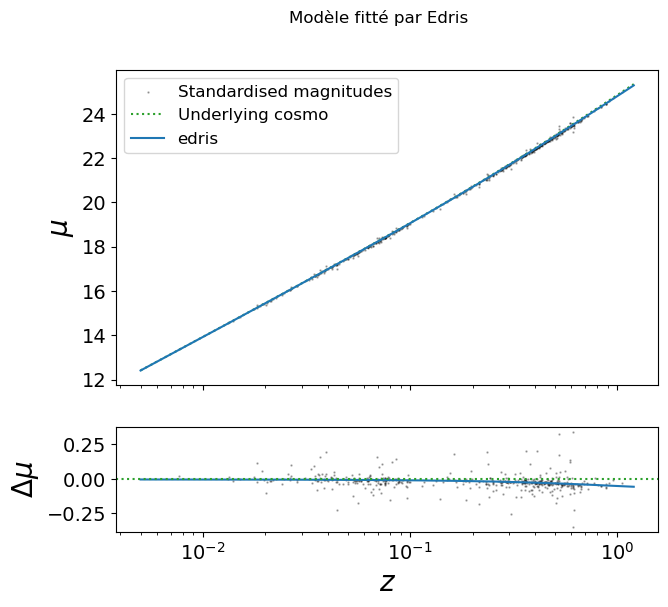

In [224]:
plot_hubble(obs, res, cov_res, flcdm, x0)

In [ ]:
mag_to_z = interp1d(
    flcdm(res, {"z": np.linspace(2e-3, 0.3, 10000)}), np.linspace(2e-3, 0.3, 10000)
)
z_cosmo_salt = mag_to_z(
    obs.mag[exp["survey_id"] == exp["survey_map"]["ZTF"]]
    - jnp.matmul(res["coef"], res["variables"])[
        exp["survey_id"] == exp["survey_map"]["ZTF"]
    ]
)

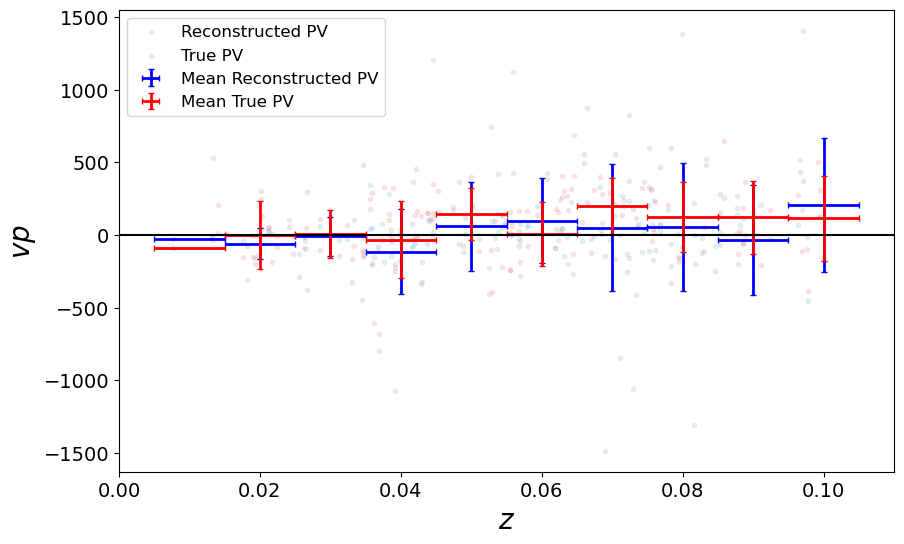

In [ ]:
data_ztf = data[data.index.isin(values[(values.survey == "ZTF") & filt].index)]
true_pv = (data_ztf.z - data_ztf.z_cosmo) * c * 1e-3 / (1 + data_ztf.z_cosmo)
edris_pv = (data_ztf.z - z_cosmo_salt) * c * 1e-3 / (1 + z_cosmo_salt)

z_max = 0.1
n_bins = 10
bounds = np.linspace(0.00, z_max, n_bins + 1)
width = z_max / n_bins
in_bins = [(data_ztf.z > z_min) & (data_ztf.z < z_min + width) for z_min in bounds]
plt.figure(figsize=(10, 6))

plt.scatter(data_ztf.z, edris_pv, marker=".", alpha=0.1, label="Reconstructed PV")
plt.scatter(
    data_ztf.z, true_pv, marker=".", color="tab:red", alpha=0.1, label="True PV"
)

plt.errorbar(
    bounds + width,
    [edris_pv[b_].mean() for b_ in in_bins],
    yerr=[edris_pv[b_].std() for b_ in in_bins],
    xerr=width / 2,
    linestyle="",
    color="blue",
    linewidth=2,
    capsize=2,
    label="Mean Reconstructed PV",
)

plt.errorbar(
    bounds + width,
    [true_pv[b_].mean() for b_ in in_bins],
    yerr=[true_pv[b_].std() for b_ in in_bins],
    xerr=width / 2,
    linestyle="",
    color="red",
    linewidth=2,
    capsize=2,
    label="Mean True PV",
)

plt.xlabel("$z$")
plt.ylabel("$vp$")
plt.legend()
plt.axhline(0, color="k")

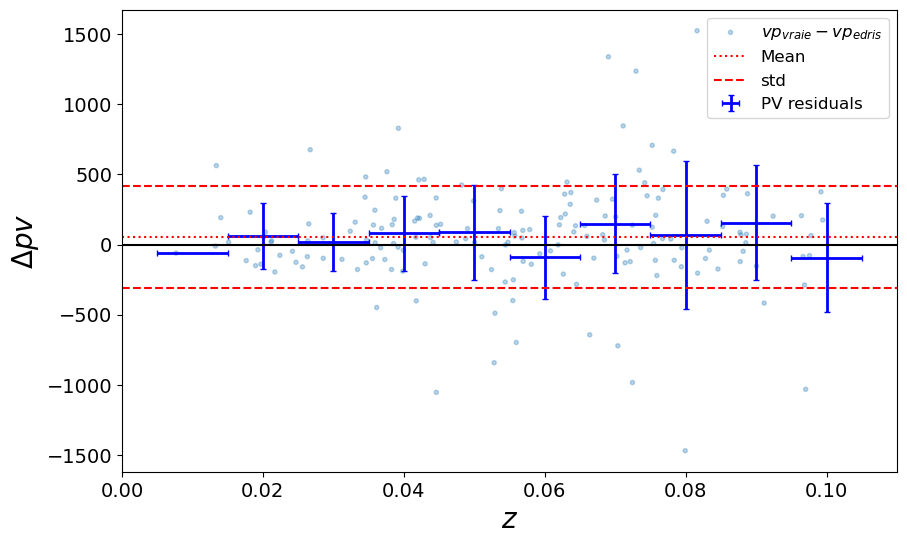

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(
    data_ztf.z,
    true_pv - edris_pv,
    marker=".",
    linestyle="",
    alpha=0.3,
    label="$vp_{vraie} - vp_{edris}$",
)
plt.errorbar(
    bounds + width,
    [(true_pv - edris_pv)[b_].mean() for b_ in in_bins],
    yerr=[(true_pv - edris_pv)[b_].std() for b_ in in_bins],
    xerr=width / 2,
    linestyle="",
    color="blue",
    linewidth=2,
    capsize=2,
    label="PV residuals",
)
plt.xlabel("$z$")
plt.ylabel(r"$\Delta pv$")
plt.axhline(0, color="k")
plt.axhline((true_pv - edris_pv).values.mean(), color="r", linestyle=":", label="Mean")
plt.axhline(
    (true_pv - edris_pv).values.mean() + (true_pv - edris_pv).values.std(),
    color="r",
    linestyle="--",
    label="std",
)
plt.axhline(
    (true_pv - edris_pv).values.mean() - (true_pv - edris_pv).values.std(),
    color="r",
    linestyle="--",
)

plt.legend()

In [225]:
(true_pv - edris_pv).values.mean(), (true_pv - edris_pv).values.std()

(54.5189937040982, 362.06071306406346)

# Power spectrum stuff

In [8]:
from cosmoprimo import *
cosmo_p = Cosmology(engine='camb')
cosmo_planck = fiducial.Planck2018FullFlatLCDM()

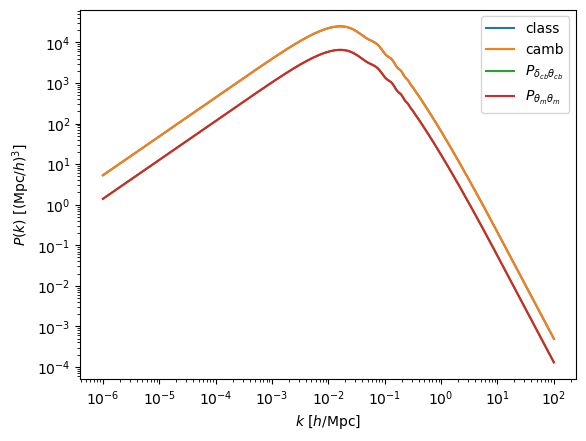

In [9]:
fo = Fourier(cosmo_p, engine='class')
pk = fo.pk_interpolator()
k = np.logspace(-6, 2, 1000)
z = 0
plt.loglog(k, pk(k, z=z), label='class')
fo_camb = cosmo_p.get_fourier(engine='camb') # second initialisation style
pk = fo_camb.pk_interpolator() # same number of cells are output than in CLASS
plt.loglog(k, pk(k, z=z), label='camb')
# cross density-velocity CDM + baryon power spectrum
plt.loglog(k,fo.pk_interpolator(of=('theta_cb', 'theta_cb'))(k, z=z), label=r'$P_{\delta_{cb}\theta_{cb}}$')
plt.loglog(k,fo.pk_interpolator(of=('theta_m', 'theta_m'))(k, z=z), label=r'$P_{\theta_{m}\theta_{m}}$')
plt.xlabel(r'$k$ [$h/\mathrm{Mpc}$]')
plt.ylabel(r'$P(k)$ [$(\mathrm{Mpc}/h)^{3}$]')
plt.legend()
plt.show()

In [10]:
k, p = np.loadtxt('test')

In [56]:
with open("./outdir/ztf_2M++_snls_hsc_DR2cuts.pkl", "rb") as file:
    values=pickle.load(file)
    covs=pickle.load(file)

In [57]:
data_ztf,_ = load_from_skysurvey('./data/dataset_2M++.pkl', survey='ZTF')
data_hsc,_ = load_from_skysurvey('./data/dataset_hsc.pkl', survey='HSC')
data_snls,_ = load_from_skysurvey('./data/dataset_snls.pkl', survey='SNLS')
data=pandas.concat([data_ztf, data_hsc, data_snls])

In [58]:
values = values.join(data[['ra','dec']])
values.ra = (values.ra/180-1)*np.pi
values.dec = values.dec/180*np.pi

In [59]:
values["rcom"] = cosmo.comoving_distance(values.z).value
values.sort_values('z', inplace=True)

In [60]:
from flip import covariance, utils
coordinates = np.array([values['ra'],
                        values['dec'],
                        values['rcom']])
sigmau_fiducial = 15

power_spectrum_dict = {"vv": [[k, p * utils.Du(k, sigmau_fiducial) ** 2]]}

size_batch=10_000
number_worker=64

covariance_fit = covariance.CovMatrix.init_from_flip(
    "carreres23",
    "velocity",
    power_spectrum_dict,
    coordinates_velocity=coordinates,
    size_batch=size_batch,
    number_worker=number_worker,
)


/home/okc/anaconda3/envs/lemaitre/lib/python3.12/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
2025-02-21 14:14:49,895 INFO Covariance matrix generated from flip with carreres23 model in 2.66e+00 seconds
[ 000239.10 ]: 02-21 14:14  root            INFO     Covariance matrix generated from flip with carreres23 model in 2.66e+00 seconds


In [61]:
covariance_fit.compute_full_matrix()

In [63]:
vpec_cov = (5/(c.value*1e-3*np.log(10)))**2*covariance_fit.covariance_dict['vv'][0] * \
            (np.array([1/values.z.values]).T @ \
             np.array([1/values.z.values]))

Text(0.5, 1.0, '$Cov_{mm}$')

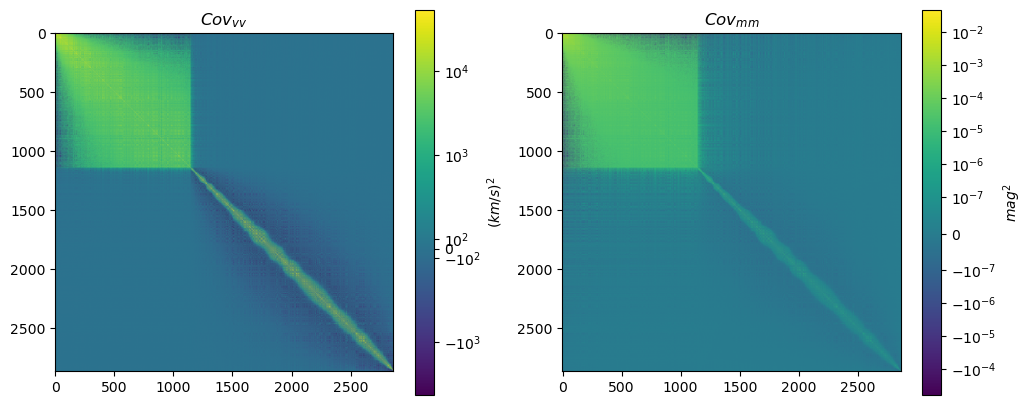

In [78]:
from matplotlib.colors import SymLogNorm
fig, (ax_vv, ax_mm) = plt.subplots(figsize=(12,5), ncols=2)
im_vv = ax_vv.imshow(covariance_fit.covariance_dict['vv'][0], norm=SymLogNorm(linthresh=1e3))
plt.colorbar(im_vv, ax=ax_vv, label=r'$(km/s)^2$')
ax_vv.set_title(r'$Cov_{vv}$')
im_mm = ax_mm.imshow(vpec_cov, norm=SymLogNorm(linthresh=1e-7))
plt.colorbar(im_mm, ax=ax_mm, label=r'$mag^2$')
ax_mm.set_title(r"$Cov_{mm}$")

In [ ]:
plt.scatter(exp['z'][exp["survey_id"] == exp['survey_map']["ZTF"]],
            true_pv[filt] - edris_vp,
            marker=".",
            linestyle='',
            alpha=0.3,
            label="$vp_{vraie} - vp_{edris}$")
mean_delta = [(true_pv[filt] - edris_vp).values[(exp['z'][exp["survey_id"] == exp['survey_map']["ZTF"]] > z_min) & \
                                         (exp['z'][exp["survey_id"] == exp['survey_map']["ZTF"]] < z_min + 0.01)].mean()
              for z_min in np.linspace(0.00, 0.05, 6)]
err_delta = [(true_pv[filt] - edris_vp).values[(exp['z'][exp["survey_id"] == exp['survey_map']["ZTF"]] > z_min) & \
                                        (exp['z'][exp["survey_id"] == exp['survey_map']["ZTF"]] < z_min + 0.01)].std()
             for z_min in np.linspace(0.00, 0.05, 6)]
plt.errorbar(np.linspace(0.00, 0.05, 6)+0.005,
             mean_delta,
             yerr=err_delta,
             xerr=0.005,
             linestyle='',
             color='tab:red',
             linewidth=2,
             capsize=2,
             label="Moyenne")

plt.xlabel("$z$")
plt.ylabel("$\Delta vp$")
plt.legend()
plt.ylim(-4000,4000)
plt.axhline(0, color='k')

In [ ]:
(true_pv[filt] - edris_vp).values.mean()